### Trying an end-to-end approach 

In [1]:
# %pip install torch torchvision pillow tqdm

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 KB 1.9 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import os
import json
from tqdm import tqdm
from random import sample

torch.cuda.empty_cache()

2.3.1


### Image transformations 

In [2]:
class ResizeAndPadTransform:
    def __init__(self, target_height=128, target_width=128):
        self.target_height = target_height
        self.target_width = target_width

    def __call__(self, img):
        w, h = img.size

        # Resize based on the larger dimension:
        if w >= h:
            if w > self.target_width:
                new_w = self.target_width
                new_h = int(round(h * self.target_width / w))
                img = transforms.Resize((new_h, new_w))(img)
        else:
            if h > self.target_height:
                new_h = self.target_height
                new_w = int(round(w * self.target_height / h))
                img = transforms.Resize((new_h, new_w))(img)

        # If it’s still larger than the target, resize it (which may slightly change the aspect ratio)
        w, h = img.size
        if w > self.target_width:
            # Resize width to target_width and scale height accordingly.
            new_w = self.target_width
            new_h = int(round(h * self.target_width / w))
            img = transforms.Resize((new_h, new_w))(img)
        if h > self.target_height:
            # Resize height to target_height and scale width accordingly.
            new_h = self.target_height
            new_w = int(round(w * self.target_height / h))
            img = transforms.Resize((new_h, new_w))(img)

        # After resizing, pad if any dimension is less than 128
        w, h = img.size
        pad_w = max(0, self.target_width - w)
        pad_h = max(0, self.target_height - h)
        left = pad_w // 2
        right = pad_w - left
        top = pad_h // 2
        bottom = pad_h - top
        img = transforms.functional.pad(img, (left, top, right, bottom), fill=0)

        # Convert to tensor and normalize
        img = transforms.ToTensor()(img)
        img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
        
        return img

In [3]:
frame_transform = transforms.Compose([
    ResizeAndPadTransform(target_height=128, target_width=128)
])

image_path = os.path.join("/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/train/images/0", "0_1.jpg")
image = Image.open(image_path).convert("RGB")
transformed_image = frame_transform(image)
print(transformed_image.shape)

torch.Size([3, 128, 128])


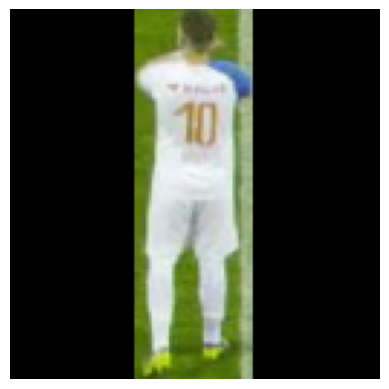

In [4]:
import matplotlib.pyplot as plt

# Convert the transformed tensor back to an image for visualization
transformed_image_np = transformed_image.permute(1, 2, 0).numpy() * 0.5 + 0.5  # Denormalize
plt.imshow(transformed_image_np)
plt.axis('off')
plt.show()

### Define Dataset and Collate function for batching variable length sequences

In [5]:
class TrackletDataset(IterableDataset):
    def __init__(self, img_dir, gt_file, transform=None, tracklet_ids=None):
        super().__init__()
        self.img_dir = img_dir
        self.gt_file = gt_file
        self.transform = transform
        with open(gt_file, "r") as f:
            self.gt_data = json.load(f)
        if tracklet_ids == None:
            self.tracklet_ids = [d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))]
        else:
            self.tracklet_ids = tracklet_ids

    def __iter__(self):
        """
        Generator function for streaming the dataset.
        Yields: (tracklet_tensor, label)
        """
        for tracklet_id in tqdm(self.tracklet_ids, desc="Streaming tracklets"):
            tracklet_path = os.path.join(self.img_dir, tracklet_id)
            label = self.gt_data[tracklet_id]

            # Load images one by one
            images = []
            for filename in sorted(os.listdir(tracklet_path)):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(tracklet_path, filename)
                    try:
                        img = Image.open(img_path).convert("RGB")
                        if self.transform:
                            img = self.transform(img)
                        images.append(img)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        continue

            if len(images) == 0:
                continue

            tracklet_tensor = torch.stack(images)

            # Use 0 for the illegible class (CrossEntropyLoss requires labels starting at 0)
            label_tensor = torch.tensor(0 if label == -1 else label)

            yield tracklet_tensor, label_tensor

def collate_fn(batch):
    """
    Since some tracklets are longer than others, we need a custom collate function to divide them into batches.
    Our approach pads each sequence to the length of the longest sequence so it may be passed to nn.utils.rnn.pack_padded_sequence().
    Each element in the batch is a tuple (tracklet_tensor, label), where each tracklet_tensor has shape (max_seq_len, C, H, W).
    """
    tracklets, labels = zip(*batch)
    seq_lengths = [t.shape[0] for t in tracklets]

    # Sort the batch in descending order of sequence lengths
    sorted_indices = sorted(range(len(seq_lengths)), key=lambda i: seq_lengths[i], reverse=True)
    sorted_tracklets = [tracklets[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_seq_lengths = [seq_lengths[i] for i in sorted_indices]

    # Pad the tracklet sequences to the maximum sequence length in the batch
    padded_tracklets = pad_sequence(sorted_tracklets, batch_first=True)

    return padded_tracklets, torch.tensor(sorted_seq_lengths), torch.tensor(sorted_labels)

### Define the backbone architecture (taken from Laura's code)

In [6]:
class JerseyNumberClassifier(nn.Module):
    def __init__(self):
        super(JerseyNumberClassifier, self).__init__()
        
        # 128x128 input
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 64x64 input
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 32x32 input
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 16x16 input
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 8x8 input
        self.block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # 4x4 input
        self.block6 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # 2x2 output instead of 1x1
        self.fc = nn.Sequential(
            nn.Linear(1024 * 2 * 2, 8192),  # Adjusted from 1024 * 1 * 1
            nn.ReLU(),
            nn.Linear(8192, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100)
        )
    
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = torch.flatten(x, start_dim=1) 
        x = self.fc(x)
        return x

In [7]:
cnn_model = torch.load("test_cnn.pth", weights_only=False)

# Checking whether .pth file contains model as well
if isinstance(cnn_model, dict):  # if only state_dict, then it means weights only
    print("Contains only weights.")
elif isinstance(cnn_model, nn.Module):  # entire model
    print("Contains the full cnn_model.")
else:
    print("Unknown format.")

Contains the full cnn_model.


In [7]:
class CNNFeatureExtractor(nn.Module):
    """Wrapper around the full model without the fc block."""
    def __init__(self, full_model):
        super(CNNFeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            full_model.block1,
            full_model.block2,
            full_model.block3,
            full_model.block4,
            full_model.block5,
            full_model.block6       # Should be 1024 channels with 2x2 activation maps
        )

    def forward(self, x):
        x = self.features(x)
        return x

In [8]:
class ImageRNN(nn.Module):
    def __init__(self, cnn_model, hidden_dim=512, num_layers=2, rnn_output_dim=100, rnn_type="LSTM", cnn_feature_dim=256):
        super(ImageRNN, self).__init__()
        # CNN feature extractor without the fc block
        self.cnn = CNNFeatureExtractor(cnn_model)
        # CNN output dimension is 1024 * 2 * 2 = 4096
        self.cnn_out_dim = 1024 * 2 * 2  
        # Projection layer: from 4096 to 256
        self.cnn_project = nn.Linear(self.cnn_out_dim, cnn_feature_dim)
        # RNN layer: input dimension is cnn_feature_dim
        rnn_cls = nn.LSTM if rnn_type == 'LSTM' else nn.GRU
        self.rnn = rnn_cls(input_size=cnn_feature_dim, hidden_size=hidden_dim, 
                           num_layers=num_layers, batch_first=True)
        # Final output layer
        self.fc = nn.Linear(hidden_dim, rnn_output_dim)

    def forward(self, x, seq_lengths):
        """
        x: Tensor of shape (batch_size, seq_len, C, H, W)
        seq_lengths: Tensor or list of actual sequence lengths for each tracklet.
        """
        batch_size, seq_len, C, H, W = x.shape
        cnn_features = []
#         print(seq_len)
        # Process each frame in the sequence
        for i in range(seq_len):
            img_batch = x[:, i]  # Shape: (batch_size, C, H, W)
            with torch.no_grad():  # Freeze CNN feature extractor if desired
                features = self.cnn(img_batch)  # Shape: (batch_size, 1024, 2, 2)
            features = features.view(batch_size, -1)  # Flatten to (batch_size, 4096)
            features = self.cnn_project(features)       # Project to (batch_size, cnn_feature_dim)
            cnn_features.append(features)
        # Stack along the time dimension: (batch_size, seq_len, cnn_feature_dim)
        cnn_features = torch.stack(cnn_features, dim=1)
        # Pack the padded sequence
        packed_seq = pack_padded_sequence(cnn_features, lengths=seq_lengths, batch_first=True, enforce_sorted=True)
        packed_out, _ = self.rnn(packed_seq)
        # Unpack the sequence
        padded_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # For each sample, select the output at the last valid time step
        last_outputs = []
        for i, length in enumerate(seq_lengths):
            last_outputs.append(padded_out[i, length - 1, :])
        last_outputs = torch.stack(last_outputs, dim=0)
        output = self.fc(last_outputs)  # Final prediction: (batch_size, rnn_output_dim)
        return output

In [9]:
IMG_DIR = r"/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/train/images/"
GT_FILE = r"/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/train/train_gt.json"

BATCH_SIZE = 4
LEARNING_RATE = 1e-4
EPOCHS = 5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [12]:
subset_fraction = 0.15

def create_subset(subset_fraction=0.15):
    tracklet_ids = [d for d in os.listdir(IMG_DIR) if os.path.isdir(os.path.join(IMG_DIR, d))]
    total_samples = len(tracklet_ids)
    num_samples = int(total_samples * subset_fraction)

    # Randomly sample the indices of tracklets to keep
    sampled_tracklet_ids = sample(tracklet_ids, num_samples)

    subset_dataset = TrackletDataset(IMG_DIR, GT_FILE, frame_transform, sampled_tracklet_ids)
    subset_dataloader = DataLoader(subset_dataset, batch_size=4, collate_fn=collate_fn)

    return subset_dataloader

# Create the subset dataloader (15% of the original dataset) to use for overfitting
subset_dataloader = create_subset(subset_fraction=subset_fraction)

In [15]:
cnn_model.eval() # freeze CNN weights 

# model = ImageRNN(cnn_model=cnn_model, hidden_dim=512, num_layers=2, cnn_feature_dim=512)
# model.to(DEVICE)

# criterion = nn.CrossEntropyLoss()  # or another appropriate loss
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
num_epochs = 30
losses = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    batch_count = 0  # Keep track of the number of batches in each epoch
    
    for batch_idx, (tracklets, seq_lengths_cpu, labels) in enumerate(subset_dataloader):
#         print(tracklets.shape, labels.shape)
        tracklets, labels = tracklets.to(DEVICE), labels.to(DEVICE)
        seq_lengths_gpu = seq_lengths_cpu.to(DEVICE)
    
        optimizer.zero_grad()
        outputs = model(tracklets, seq_lengths_cpu)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track statistics
        running_loss += loss.item()
        
        print(f"Batch {batch_idx + 1}, Loss: {loss.item():.4f}")
        
        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
        batch_count += 1

    epoch_loss = running_loss / batch_count
    losses.append(epoch_loss)
    accuracy = correct_predictions / total_predictions * 100
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

Streaming tracklets:   4%|██▎                                                           | 8/214 [00:20<10:28,  3.05s/it]

Batch 1, Loss: 4.6143


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:24<15:20,  4.47s/it]

Batch 2, Loss: 4.5829


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:29<20:47,  6.06s/it]

Batch 3, Loss: 4.5511


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:32<13:53,  4.13s/it]

Batch 4, Loss: 4.5176


Streaming tracklets:   7%|███▉                                                         | 14/214 [00:36<09:27,  2.84s/it]

Batch 5, Loss: 4.5378


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:40<18:20,  5.45s/it]

Batch 6, Loss: 4.5121


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:45<20:10,  5.99s/it]

Batch 7, Loss: 4.4787


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:50<18:08,  5.50s/it]

Batch 8, Loss: 4.4377


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:53<19:09,  5.81s/it]

Batch 9, Loss: 4.5447


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:57<17:46,  5.39s/it]

Batch 10, Loss: 4.5197


Streaming tracklets:   9%|█████▍                                                       | 19/214 [01:01<09:23,  2.89s/it]

Batch 11, Loss: 4.4858


Streaming tracklets:   9%|█████▍                                                       | 19/214 [01:05<09:03,  2.79s/it]

Batch 12, Loss: 4.4420


Streaming tracklets:  10%|██████▎                                                      | 22/214 [01:09<11:23,  3.56s/it]

Batch 13, Loss: 4.5470


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:13<18:20,  5.68s/it]

Batch 14, Loss: 4.5201


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:18<19:24,  6.00s/it]

Batch 15, Loss: 4.4791


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:23<18:04,  5.71s/it]

Batch 16, Loss: 4.4236


Streaming tracklets:  12%|███████▍                                                     | 26/214 [01:27<12:02,  3.84s/it]

Batch 17, Loss: 4.4449


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:31<18:18,  5.78s/it]

Batch 18, Loss: 4.3972


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:35<17:52,  5.65s/it]

Batch 19, Loss: 4.3268


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:38<16:27,  5.31s/it]

Batch 20, Loss: 4.2345


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:42<17:12,  5.55s/it]

Batch 21, Loss: 4.1412


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:46<16:52,  5.44s/it]

Batch 22, Loss: 4.0634


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:50<16:54,  5.46s/it]

Batch 23, Loss: 3.9647


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:54<16:18,  5.38s/it]

Batch 24, Loss: 3.8486


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:57<16:22,  5.40s/it]

Batch 25, Loss: 2.9159


Streaming tracklets:  15%|█████████                                                    | 32/214 [02:01<16:11,  5.34s/it]

Batch 26, Loss: 2.7015


Streaming tracklets:  15%|█████████                                                    | 32/214 [02:06<16:55,  5.58s/it]

Batch 27, Loss: 2.4625


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:10<15:51,  5.35s/it]

Batch 28, Loss: 2.2165


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:14<16:53,  5.69s/it]

Batch 29, Loss: 3.9695


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:18<16:27,  5.55s/it]

Batch 30, Loss: 3.9739


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:21<15:56,  5.37s/it]

Batch 31, Loss: 3.9249


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:25<15:18,  5.28s/it]

Batch 32, Loss: 3.8315


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:28<15:19,  5.29s/it]

Batch 33, Loss: 3.4434


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:32<15:25,  5.32s/it]

Batch 34, Loss: 3.4038


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:36<15:34,  5.37s/it]

Batch 35, Loss: 3.3355


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:40<14:40,  5.18s/it]

Batch 36, Loss: 3.2468


Streaming tracklets:  21%|█████████████                                                | 46/214 [02:44<09:56,  3.55s/it]

Batch 37, Loss: 4.3367


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:48<15:10,  5.36s/it]

Batch 38, Loss: 4.2660


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:51<14:55,  5.27s/it]

Batch 39, Loss: 4.1748


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [02:55<14:05,  5.09s/it]

Batch 40, Loss: 4.0713


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [02:59<14:31,  5.25s/it]

Batch 41, Loss: 4.8663


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:03<14:18,  5.17s/it]

Batch 42, Loss: 4.7976


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:06<14:20,  5.18s/it]

Batch 43, Loss: 4.7108


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:10<13:48,  5.11s/it]

Batch 44, Loss: 4.6116


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:13<14:06,  5.23s/it]

Batch 45, Loss: 3.9048


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:17<13:42,  5.08s/it]

Batch 46, Loss: 3.8754


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:21<13:44,  5.09s/it]

Batch 47, Loss: 3.8321


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:24<13:02,  4.96s/it]

Batch 48, Loss: 3.7778


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:27<13:02,  4.95s/it]

Batch 49, Loss: 3.0250


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:30<12:47,  4.86s/it]

Batch 50, Loss: 3.0005


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:33<12:17,  4.67s/it]

Batch 51, Loss: 2.9582


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:36<11:20,  4.42s/it]

Batch 52, Loss: 2.9016


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:39<11:11,  4.36s/it]

Batch 53, Loss: 3.6573


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:43<11:38,  4.54s/it]

Batch 54, Loss: 3.5811


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:46<11:51,  4.62s/it]

Batch 55, Loss: 3.4935


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:49<11:24,  4.56s/it]

Batch 56, Loss: 3.3978


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:52<11:13,  4.49s/it]

Batch 57, Loss: 3.7073


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:55<10:43,  4.29s/it]

Batch 58, Loss: 3.6645


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:58<10:55,  4.37s/it]

Batch 59, Loss: 3.6101


Streaming tracklets:  31%|███████████████████                                          | 67/214 [04:01<05:34,  2.28s/it]

Batch 60, Loss: 3.5474


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:05<11:29,  4.72s/it]

Batch 61, Loss: 4.9355


Streaming tracklets:  33%|████████████████████▏                                        | 71/214 [04:09<05:57,  2.50s/it]

Batch 62, Loss: 4.9137


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:14<12:58,  5.33s/it]

Batch 63, Loss: 4.8700


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:18<12:24,  5.25s/it]

Batch 64, Loss: 4.8093


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:21<12:37,  5.34s/it]

Batch 65, Loss: 2.9452


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:25<12:54,  5.45s/it]

Batch 66, Loss: 2.9349


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:29<12:37,  5.33s/it]

Batch 67, Loss: 2.9138


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:33<12:10,  5.29s/it]

Batch 68, Loss: 2.8839


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:36<12:16,  5.34s/it]

Batch 69, Loss: 3.8549


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:40<12:18,  5.35s/it]

Batch 70, Loss: 3.8306


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:44<12:08,  5.28s/it]

Batch 71, Loss: 3.7961


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:47<11:21,  5.08s/it]

Batch 72, Loss: 3.7536


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:51<11:43,  5.25s/it]

Batch 73, Loss: 2.2713


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:54<11:20,  5.08s/it]

Batch 74, Loss: 2.2579


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:57<11:05,  4.97s/it]

Batch 75, Loss: 2.2300


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:01<10:47,  4.98s/it]

Batch 76, Loss: 2.1911


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:04<10:32,  4.86s/it]

Batch 77, Loss: 4.3304


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:08<11:05,  5.12s/it]

Batch 78, Loss: 4.3093


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:12<11:23,  5.26s/it]

Batch 79, Loss: 4.2749


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:16<10:50,  5.16s/it]

Batch 80, Loss: 4.2299


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:20<11:18,  5.38s/it]

Batch 81, Loss: 1.0431


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:23<11:12,  5.34s/it]

Batch 82, Loss: 1.0191


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:27<11:08,  5.31s/it]

Batch 83, Loss: 0.9786


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:30<10:25,  5.13s/it]

Batch 84, Loss: 0.9255


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:34<10:31,  5.18s/it]

Batch 85, Loss: 2.5878


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:37<10:07,  4.98s/it]

Batch 86, Loss: 2.5820


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:40<09:56,  4.89s/it]

Batch 87, Loss: 2.5635


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:43<09:28,  4.82s/it]

Batch 88, Loss: 2.5337


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:46<09:34,  4.87s/it]

Batch 89, Loss: 1.2947


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:50<09:42,  4.94s/it]

Batch 90, Loss: 1.2849


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:53<09:57,  5.07s/it]

Batch 91, Loss: 1.2708


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [05:57<07:59,  4.21s/it]

Batch 92, Loss: 1.2532


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [05:59<07:38,  4.02s/it]

Batch 93, Loss: 4.0377


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:01<07:07,  3.75s/it]

Batch 94, Loss: 4.0394


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:05<07:02,  3.71s/it]

Batch 95, Loss: 4.0251


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:08<07:13,  3.94s/it]

Batch 96, Loss: 3.9975


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:14<08:35,  4.69s/it]

Batch 97, Loss: 2.9724


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:17<08:33,  4.67s/it]

Batch 98, Loss: 2.9521


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:21<09:00,  4.91s/it]

Batch 99, Loss: 2.9229


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:25<08:59,  5.09s/it]

Batch 100, Loss: 2.8862


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:28<08:46,  4.96s/it]

Batch 101, Loss: 3.2779


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:32<09:00,  5.10s/it]

Batch 102, Loss: 3.2674


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:36<09:16,  5.25s/it]

Batch 103, Loss: 3.2487


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:40<09:06,  5.36s/it]

Batch 104, Loss: 3.2237


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:44<09:16,  5.45s/it]

Batch 105, Loss: 3.9253


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:48<09:30,  5.59s/it]

Batch 106, Loss: 3.9016


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:53<09:58,  5.87s/it]

Batch 107, Loss: 3.8670


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [06:57<09:00,  5.51s/it]

Batch 108, Loss: 3.8240


Streaming tracklets:  55%|█████████████████████████████████                           | 118/214 [07:01<05:52,  3.67s/it]

Batch 109, Loss: 2.9985


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:05<09:23,  5.75s/it]

Batch 110, Loss: 2.9843


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:09<09:12,  5.64s/it]

Batch 111, Loss: 2.9639


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:13<08:12,  5.24s/it]

Batch 112, Loss: 2.9383


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:16<08:20,  5.33s/it]

Batch 113, Loss: 4.1985


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:20<08:12,  5.24s/it]

Batch 114, Loss: 4.1589


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:23<07:54,  5.05s/it]

Batch 115, Loss: 4.1014


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:26<07:10,  4.79s/it]

Batch 116, Loss: 4.0305


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:29<07:19,  4.89s/it]

Batch 117, Loss: 3.0634


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:33<07:26,  4.97s/it]

Batch 118, Loss: 3.0598


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:38<08:13,  5.48s/it]

Batch 119, Loss: 3.0484


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:42<07:50,  5.47s/it]

Batch 120, Loss: 3.0303


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:46<08:09,  5.69s/it]

Batch 121, Loss: 3.4209


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:50<07:54,  5.52s/it]

Batch 122, Loss: 3.3975


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:54<07:35,  5.30s/it]

Batch 123, Loss: 3.3669


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [07:57<07:05,  5.19s/it]

Batch 124, Loss: 3.3303


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:01<07:02,  5.15s/it]

Batch 125, Loss: 4.8351


Streaming tracklets:  63%|█████████████████████████████████████▊                      | 135/214 [08:05<03:23,  2.58s/it]

Batch 126, Loss: 4.8004


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:08<07:09,  5.24s/it]

Batch 127, Loss: 4.7506


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:12<06:40,  5.14s/it]

Batch 128, Loss: 4.6890


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:15<06:31,  5.02s/it]

Batch 129, Loss: 3.3793


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:19<06:43,  5.17s/it]

Batch 130, Loss: 3.3557


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:23<06:48,  5.23s/it]

Batch 131, Loss: 3.3208


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:27<06:19,  5.13s/it]

Batch 132, Loss: 3.2763


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:31<06:36,  5.36s/it]

Batch 133, Loss: 3.2430


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:34<06:31,  5.28s/it]

Batch 134, Loss: 3.2438


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:38<06:29,  5.26s/it]

Batch 135, Loss: 3.2335


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:42<06:01,  5.16s/it]

Batch 136, Loss: 3.2137


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:45<06:10,  5.29s/it]

Batch 137, Loss: 3.7846


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:49<06:07,  5.26s/it]

Batch 138, Loss: 3.7665


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:53<06:06,  5.23s/it]

Batch 139, Loss: 3.7380


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [08:56<05:47,  5.26s/it]

Batch 140, Loss: 3.7007


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:00<05:50,  5.31s/it]

Batch 141, Loss: 4.2036


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:04<05:58,  5.44s/it]

Batch 142, Loss: 4.1872


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:08<05:57,  5.42s/it]

Batch 143, Loss: 4.1585


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:11<05:28,  5.29s/it]

Batch 144, Loss: 4.1195


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:15<05:29,  5.32s/it]

Batch 145, Loss: 2.5505


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:18<05:21,  5.18s/it]

Batch 146, Loss: 2.5246


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:22<05:24,  5.23s/it]

Batch 147, Loss: 2.4848


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:26<04:54,  5.07s/it]

Batch 148, Loss: 2.4337


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:29<04:55,  5.10s/it]

Batch 149, Loss: 2.9274


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:33<04:58,  5.14s/it]

Batch 150, Loss: 2.8936


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:36<04:59,  5.16s/it]

Batch 151, Loss: 2.8547


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:40<04:37,  5.14s/it]

Batch 152, Loss: 2.8119


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:44<04:44,  5.26s/it]

Batch 153, Loss: 3.4394


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:47<04:45,  5.29s/it]

Batch 154, Loss: 3.4365


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:51<04:49,  5.36s/it]

Batch 155, Loss: 3.4242


Streaming tracklets:  77%|█████████████████████████████████████████████▉              | 164/214 [09:55<04:26,  5.32s/it]

Batch 156, Loss: 3.4040


Streaming tracklets:  77%|█████████████████████████████████████████████▉              | 164/214 [09:59<04:31,  5.43s/it]

Batch 157, Loss: 3.0653


Streaming tracklets:  77%|█████████████████████████████████████████████▉              | 164/214 [10:02<04:20,  5.20s/it]

Batch 158, Loss: 3.0464


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:05<02:54,  3.56s/it]

Batch 159, Loss: 3.0208


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:08<03:50,  5.02s/it]

Batch 160, Loss: 2.9896


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:11<03:42,  4.84s/it]

Batch 161, Loss: 3.6505


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:15<03:42,  4.84s/it]

Batch 162, Loss: 3.6421


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:18<03:47,  4.94s/it]

Batch 163, Loss: 3.6146


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:21<03:26,  4.91s/it]

Batch 164, Loss: 3.5708


Streaming tracklets:  81%|████████████████████████████████████████████████▊           | 174/214 [10:24<02:01,  3.03s/it]

Batch 165, Loss: 2.3193


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:26<02:54,  4.15s/it]

Batch 166, Loss: 2.3184


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:31<03:05,  4.41s/it]

Batch 167, Loss: 2.3111


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:34<02:51,  4.50s/it]

Batch 168, Loss: 2.2981


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:38<03:02,  4.80s/it]

Batch 169, Loss: 1.7064


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:42<03:00,  4.74s/it]

Batch 170, Loss: 1.6946


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:44<02:48,  4.44s/it]

Batch 171, Loss: 1.6748


Streaming tracklets:  84%|██████████████████████████████████████████████████▍         | 180/214 [10:47<02:32,  4.48s/it]

Batch 172, Loss: 1.6484


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [10:50<01:44,  3.16s/it]

Batch 173, Loss: 3.6639


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [10:54<01:46,  3.24s/it]

Batch 174, Loss: 3.6587


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [10:57<01:48,  3.29s/it]

Batch 175, Loss: 3.6433


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:00<02:21,  4.73s/it]

Batch 176, Loss: 3.6191


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:02<02:15,  4.52s/it]

Batch 177, Loss: 2.0438


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:05<02:09,  4.32s/it]

Batch 178, Loss: 2.0328


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:07<02:04,  4.14s/it]

Batch 179, Loss: 2.0175


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:10<01:29,  3.44s/it]

Batch 180, Loss: 1.9987


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:12<01:28,  3.40s/it]

Batch 181, Loss: 2.8807


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:15<01:31,  3.53s/it]

Batch 182, Loss: 2.8759


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:18<01:32,  3.57s/it]

Batch 183, Loss: 2.8559


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:21<01:29,  4.05s/it]

Batch 184, Loss: 2.8232


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:23<01:28,  4.00s/it]

Batch 185, Loss: 2.3237


Streaming tracklets:  91%|██████████████████████████████████████████████████████▍     | 194/214 [11:26<00:54,  2.73s/it]

Batch 186, Loss: 2.3226


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:30<01:31,  4.16s/it]

Batch 187, Loss: 2.3149


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:33<01:14,  4.12s/it]

Batch 188, Loss: 2.3015


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:38<01:24,  4.68s/it]

Batch 189, Loss: 3.1060


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:42<01:27,  4.86s/it]

Batch 190, Loss: 3.0984


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:46<01:30,  5.01s/it]

Batch 191, Loss: 3.0819


Streaming tracklets:  93%|████████████████████████████████████████████████████████    | 200/214 [11:49<01:10,  5.05s/it]

Batch 192, Loss: 3.0581


Streaming tracklets:  93%|████████████████████████████████████████████████████████    | 200/214 [11:53<01:13,  5.29s/it]

Batch 193, Loss: 3.0965


Streaming tracklets:  93%|████████████████████████████████████████████████████████    | 200/214 [11:56<01:10,  5.06s/it]

Batch 194, Loss: 3.0813


Streaming tracklets:  93%|████████████████████████████████████████████████████████    | 200/214 [11:59<01:08,  4.87s/it]

Batch 195, Loss: 3.0433


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:02<00:48,  4.84s/it]

Batch 196, Loss: 2.9868


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:05<00:47,  4.74s/it]

Batch 197, Loss: 1.6014


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:09<00:47,  4.75s/it]

Batch 198, Loss: 1.6098


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:13<00:48,  4.84s/it]

Batch 199, Loss: 1.6095


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:16<00:29,  4.97s/it]

Batch 200, Loss: 1.6011


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:18<00:28,  4.69s/it]

Batch 201, Loss: 1.7867


Streaming tracklets:  98%|██████████████████████████████████████████████████████████▉ | 210/214 [12:21<00:11,  2.96s/it]

Batch 202, Loss: 1.7781


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:24<00:26,  4.39s/it]

Batch 203, Loss: 1.7630


Streaming tracklets:  98%|██████████████████████████████████████████████████████████▉ | 210/214 [12:28<00:12,  3.01s/it]

Batch 204, Loss: 1.7423


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:32<00:09,  4.55s/it]

Batch 205, Loss: 3.3889


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:35<00:08,  4.46s/it]

Batch 206, Loss: 3.3795


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:37<00:08,  4.23s/it]

Batch 207, Loss: 3.3592


Streaming tracklets: 100%|████████████████████████████████████████████████████████████| 214/214 [12:39<00:00,  3.55s/it]


Batch 208, Loss: 3.3298
Batch 209, Loss: 3.7194
Batch 210, Loss: 3.7083
Batch 211, Loss: 3.6843
Batch 212, Loss: 3.6497
Batch 213, Loss: 5.6973
Batch 214, Loss: 5.6249
Batch 215, Loss: 5.5240
Batch 216, Loss: 5.4018
Epoch 1/30, Loss: 3.3601, Accuracy: 32.71%


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:18<08:34,  2.50s/it]

Batch 1, Loss: 2.8186


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:25<15:54,  4.63s/it]

Batch 2, Loss: 2.8102


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:30<20:17,  5.91s/it]

Batch 3, Loss: 2.7960


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:33<13:46,  4.09s/it]

Batch 4, Loss: 2.7769


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:36<16:47,  4.99s/it]

Batch 5, Loss: 2.7443


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:40<17:08,  5.09s/it]

Batch 6, Loss: 2.7284


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:44<18:08,  5.39s/it]

Batch 7, Loss: 2.7079


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:49<16:52,  5.11s/it]

Batch 8, Loss: 2.6834


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:52<17:32,  5.31s/it]

Batch 9, Loss: 3.4022


Streaming tracklets:   9%|█████▍                                                       | 19/214 [00:56<08:45,  2.69s/it]

Batch 10, Loss: 3.3897


Streaming tracklets:   7%|████▌                                                        | 16/214 [01:00<17:04,  5.17s/it]

Batch 11, Loss: 3.3695


Streaming tracklets:   9%|█████▍                                                       | 19/214 [01:03<08:34,  2.64s/it]

Batch 12, Loss: 3.3430


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:08<17:31,  5.42s/it]

Batch 13, Loss: 3.3726


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:12<17:45,  5.49s/it]

Batch 14, Loss: 3.3577


Streaming tracklets:  11%|██████▌                                                      | 23/214 [01:17<09:02,  2.84s/it]

Batch 15, Loss: 3.3340


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:21<18:02,  5.70s/it]

Batch 16, Loss: 3.3029


Streaming tracklets:  13%|███████▋                                                     | 27/214 [01:25<09:00,  2.89s/it]

Batch 17, Loss: 3.5651


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:29<18:00,  5.69s/it]

Batch 18, Loss: 3.5564


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:33<17:33,  5.54s/it]

Batch 19, Loss: 3.5381


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:37<16:54,  5.45s/it]

Batch 20, Loss: 3.5119


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:40<16:36,  5.36s/it]

Batch 21, Loss: 3.5242


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:44<16:42,  5.39s/it]

Batch 22, Loss: 3.5073


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:48<17:00,  5.48s/it]

Batch 23, Loss: 3.4818


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:52<16:54,  5.57s/it]

Batch 24, Loss: 3.4495


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:56<16:40,  5.50s/it]

Batch 25, Loss: 1.9500


Streaming tracklets:  15%|█████████                                                    | 32/214 [02:00<16:50,  5.55s/it]

Batch 26, Loss: 1.9456


Streaming tracklets:  15%|█████████                                                    | 32/214 [02:04<16:54,  5.58s/it]

Batch 27, Loss: 1.9294


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:08<16:32,  5.58s/it]

Batch 28, Loss: 1.9032


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:12<16:33,  5.58s/it]

Batch 29, Loss: 3.4083


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:16<16:45,  5.65s/it]

Batch 30, Loss: 3.4049


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:20<16:09,  5.45s/it]

Batch 31, Loss: 3.3875


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:24<15:47,  5.45s/it]

Batch 32, Loss: 3.3580


Streaming tracklets:  20%|████████████▎                                                | 43/214 [02:27<07:28,  2.63s/it]

Batch 33, Loss: 2.4951


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:31<15:28,  5.34s/it]

Batch 34, Loss: 2.4931


Streaming tracklets:  20%|████████████▎                                                | 43/214 [02:35<07:48,  2.74s/it]

Batch 35, Loss: 2.4812


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:39<15:05,  5.33s/it]

Batch 36, Loss: 2.4607


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:43<15:05,  5.33s/it]

Batch 37, Loss: 3.5190


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:47<15:26,  5.45s/it]

Batch 38, Loss: 3.5120


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:51<15:45,  5.56s/it]

Batch 39, Loss: 3.4939


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [02:55<15:14,  5.51s/it]

Batch 40, Loss: 3.4664


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [02:59<15:06,  5.46s/it]

Batch 41, Loss: 3.8926


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:03<14:49,  5.36s/it]

Batch 42, Loss: 3.8828


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:06<14:23,  5.20s/it]

Batch 43, Loss: 3.8608


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:10<14:10,  5.25s/it]

Batch 44, Loss: 3.8284


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:13<14:06,  5.22s/it]

Batch 45, Loss: 3.6514


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:17<13:56,  5.16s/it]

Batch 46, Loss: 3.6326


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:21<13:49,  5.12s/it]

Batch 47, Loss: 3.6044


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:24<13:25,  5.10s/it]

Batch 48, Loss: 3.5677


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:27<13:20,  5.07s/it]

Batch 49, Loss: 2.6237


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:30<12:54,  4.90s/it]

Batch 50, Loss: 2.6170


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:33<12:29,  4.74s/it]

Batch 51, Loss: 2.6011


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:37<11:52,  4.62s/it]

Batch 52, Loss: 2.5772


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:40<11:40,  4.55s/it]

Batch 53, Loss: 3.1165


Streaming tracklets:  29%|█████████████████▉                                           | 63/214 [03:43<05:37,  2.23s/it]

Batch 54, Loss: 3.0880


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:47<12:22,  4.82s/it]

Batch 55, Loss: 3.0493


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:50<12:07,  4.85s/it]

Batch 56, Loss: 3.0017


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:54<11:54,  4.76s/it]

Batch 57, Loss: 2.9674


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:57<11:50,  4.74s/it]

Batch 58, Loss: 2.9501


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [04:00<11:15,  4.51s/it]

Batch 59, Loss: 2.9232


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:03<10:59,  4.51s/it]

Batch 60, Loss: 2.8890


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:07<11:50,  4.87s/it]

Batch 61, Loss: 4.0989


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:11<12:20,  5.07s/it]

Batch 62, Loss: 4.0963


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:15<13:08,  5.40s/it]

Batch 63, Loss: 4.0783


Streaming tracklets:  33%|████████████████████▏                                        | 71/214 [04:20<06:27,  2.71s/it]

Batch 64, Loss: 4.0474


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:24<13:00,  5.50s/it]

Batch 65, Loss: 2.5746


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:27<13:03,  5.52s/it]

Batch 66, Loss: 2.5737


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:31<12:39,  5.35s/it]

Batch 67, Loss: 2.5638


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:35<12:35,  5.48s/it]

Batch 68, Loss: 2.5459


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:39<12:26,  5.41s/it]

Batch 69, Loss: 3.3161


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:42<12:31,  5.44s/it]

Batch 70, Loss: 3.2977


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:46<12:25,  5.40s/it]

Batch 71, Loss: 3.2719


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:50<11:52,  5.32s/it]

Batch 72, Loss: 3.2384


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:53<11:43,  5.25s/it]

Batch 73, Loss: 2.1778


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:57<11:34,  5.18s/it]

Batch 74, Loss: 2.1676


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [05:00<11:19,  5.07s/it]

Batch 75, Loss: 2.1455


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:03<11:06,  5.12s/it]

Batch 76, Loss: 2.1142


Streaming tracklets:  41%|████████████████████████▊                                    | 87/214 [05:06<05:10,  2.44s/it]

Batch 77, Loss: 3.7293


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:10<10:56,  5.05s/it]

Batch 78, Loss: 3.7214


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:13<10:46,  4.97s/it]

Batch 79, Loss: 3.7022


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:17<10:35,  5.04s/it]

Batch 80, Loss: 3.6731


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:22<11:11,  5.33s/it]

Batch 81, Loss: 1.0955


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:26<11:08,  5.30s/it]

Batch 82, Loss: 1.0723


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:29<10:58,  5.23s/it]

Batch 83, Loss: 1.0344


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:33<10:33,  5.19s/it]

Batch 84, Loss: 0.9852


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:36<10:25,  5.12s/it]

Batch 85, Loss: 2.5298


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:39<10:01,  4.93s/it]

Batch 86, Loss: 2.5290


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:42<09:47,  4.81s/it]

Batch 87, Loss: 2.5182


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:45<09:30,  4.83s/it]

Batch 88, Loss: 2.4982


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:48<09:26,  4.80s/it]

Batch 89, Loss: 1.3074


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:52<09:41,  4.93s/it]

Batch 90, Loss: 1.2975


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:56<09:51,  5.01s/it]

Batch 91, Loss: 1.2843


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [05:59<08:10,  4.30s/it]

Batch 92, Loss: 1.2684


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:01<07:41,  4.05s/it]

Batch 93, Loss: 3.4335


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:04<07:14,  3.82s/it]

Batch 94, Loss: 3.4378


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:07<07:12,  3.79s/it]

Batch 95, Loss: 3.4308


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:11<07:12,  3.93s/it]

Batch 96, Loss: 3.4140


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:16<08:35,  4.69s/it]

Batch 97, Loss: 2.7893


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:20<08:58,  4.89s/it]

Batch 98, Loss: 2.7792


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:24<09:06,  4.97s/it]

Batch 99, Loss: 2.7619


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:28<09:39,  5.47s/it]

Batch 100, Loss: 2.7383


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:32<09:12,  5.21s/it]

Batch 101, Loss: 2.6360


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:36<09:15,  5.24s/it]

Batch 102, Loss: 2.6322


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:40<09:45,  5.52s/it]

Batch 103, Loss: 2.6222


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:45<09:45,  5.74s/it]

Batch 104, Loss: 2.6078


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:49<09:46,  5.75s/it]

Batch 105, Loss: 3.3279


Streaming tracklets:  54%|████████████████████████████████▏                           | 115/214 [06:53<04:47,  2.90s/it]

Batch 106, Loss: 3.3145


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:57<10:02,  5.91s/it]

Batch 107, Loss: 3.2908


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:02<09:39,  5.91s/it]

Batch 108, Loss: 3.2587


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:06<09:35,  5.88s/it]

Batch 109, Loss: 2.4272


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:10<09:35,  5.87s/it]

Batch 110, Loss: 2.4205


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:14<09:19,  5.71s/it]

Batch 111, Loss: 2.4090


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:18<08:57,  5.72s/it]

Batch 112, Loss: 2.3929


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:22<08:43,  5.56s/it]

Batch 113, Loss: 3.7956


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:25<08:37,  5.50s/it]

Batch 114, Loss: 3.7694


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:28<08:17,  5.29s/it]

Batch 115, Loss: 3.7270


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:32<07:41,  5.13s/it]

Batch 116, Loss: 3.6710


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:35<07:35,  5.06s/it]

Batch 117, Loss: 2.9103


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:39<07:47,  5.19s/it]

Batch 118, Loss: 2.9031


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:43<08:04,  5.39s/it]

Batch 119, Loss: 2.8857


Streaming tracklets:  59%|███████████████████████████████████▌                        | 127/214 [07:48<04:14,  2.93s/it]

Batch 120, Loss: 2.8616


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:52<08:03,  5.62s/it]

Batch 121, Loss: 3.1738


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:56<07:56,  5.54s/it]

Batch 122, Loss: 3.1597


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [08:00<07:42,  5.37s/it]

Batch 123, Loss: 3.1371


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:03<07:13,  5.29s/it]

Batch 124, Loss: 3.1070


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:07<07:10,  5.25s/it]

Batch 125, Loss: 4.4468


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:11<07:15,  5.32s/it]

Batch 126, Loss: 4.4170


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:15<07:23,  5.41s/it]

Batch 127, Loss: 4.3724


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:19<07:04,  5.45s/it]

Batch 128, Loss: 4.3155


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:23<06:59,  5.38s/it]

Batch 129, Loss: 3.3063


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:26<06:54,  5.32s/it]

Batch 130, Loss: 3.2848


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:30<06:54,  5.32s/it]

Batch 131, Loss: 3.2504


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:34<06:43,  5.45s/it]

Batch 132, Loss: 3.2045


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:38<06:44,  5.47s/it]

Batch 133, Loss: 2.8794


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:42<06:40,  5.41s/it]

Batch 134, Loss: 2.8866


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:45<06:31,  5.29s/it]

Batch 135, Loss: 2.8798


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:49<06:07,  5.25s/it]

Batch 136, Loss: 2.8619


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:52<06:00,  5.15s/it]

Batch 137, Loss: 3.3212


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:56<05:54,  5.06s/it]

Batch 138, Loss: 3.3041


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:59<05:54,  5.07s/it]

Batch 139, Loss: 3.2758


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:03<05:36,  5.10s/it]

Batch 140, Loss: 3.2374


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:06<05:36,  5.09s/it]

Batch 141, Loss: 3.7990


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:10<05:42,  5.19s/it]

Batch 142, Loss: 3.7849


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:14<05:49,  5.29s/it]

Batch 143, Loss: 3.7579


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:18<05:28,  5.29s/it]

Batch 144, Loss: 3.7207


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:21<05:30,  5.34s/it]

Batch 145, Loss: 2.2202


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:25<05:28,  5.31s/it]

Batch 146, Loss: 2.1962


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:29<05:30,  5.34s/it]

Batch 147, Loss: 2.1574


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:32<05:07,  5.29s/it]

Batch 148, Loss: 2.1110


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:36<05:10,  5.35s/it]

Batch 149, Loss: 2.6410


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:40<05:07,  5.30s/it]

Batch 150, Loss: 2.6028


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:43<05:06,  5.28s/it]

Batch 151, Loss: 2.5597


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:47<04:50,  5.37s/it]

Batch 152, Loss: 2.5131


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:51<04:43,  5.25s/it]

Batch 153, Loss: 3.1823


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:54<04:47,  5.33s/it]

Batch 154, Loss: 3.1842


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:58<04:46,  5.31s/it]

Batch 155, Loss: 3.1730


Streaming tracklets:  77%|█████████████████████████████████████████████▉              | 164/214 [10:02<04:24,  5.30s/it]

Batch 156, Loss: 3.1525


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:06<03:05,  3.79s/it]

Batch 157, Loss: 2.5531


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:09<02:58,  3.65s/it]

Batch 158, Loss: 2.5419


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:12<02:52,  3.52s/it]

Batch 159, Loss: 2.5241


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:15<03:48,  4.97s/it]

Batch 160, Loss: 2.5005


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:18<03:42,  4.85s/it]

Batch 161, Loss: 3.5898


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:21<03:43,  4.85s/it]

Batch 162, Loss: 3.5769


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:25<03:43,  4.85s/it]

Batch 163, Loss: 3.5423


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:28<03:25,  4.88s/it]

Batch 164, Loss: 3.4885


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:30<03:16,  4.67s/it]

Batch 165, Loss: 2.0940


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:34<03:14,  4.62s/it]

Batch 166, Loss: 2.0856


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:37<03:19,  4.75s/it]

Batch 167, Loss: 2.0523


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:41<02:53,  4.56s/it]

Batch 168, Loss: 2.0076


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:45<03:05,  4.88s/it]

Batch 169, Loss: 1.6648


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:48<02:58,  4.69s/it]

Batch 170, Loss: 1.6457


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:51<02:47,  4.41s/it]

Batch 171, Loss: 1.6190


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [10:53<01:45,  3.21s/it]

Batch 172, Loss: 1.5872


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [10:57<01:42,  3.11s/it]

Batch 173, Loss: 3.4757


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [11:00<01:45,  3.18s/it]

Batch 174, Loss: 3.4766


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [11:03<01:47,  3.27s/it]

Batch 175, Loss: 3.4634


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:07<02:26,  4.90s/it]

Batch 176, Loss: 3.4405


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:09<02:19,  4.64s/it]

Batch 177, Loss: 2.1451


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:12<02:11,  4.39s/it]

Batch 178, Loss: 2.1095


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:14<02:03,  4.13s/it]

Batch 179, Loss: 2.0658


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:16<01:29,  3.44s/it]

Batch 180, Loss: 2.0255


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:19<01:27,  3.38s/it]

Batch 181, Loss: 2.6546


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:22<01:29,  3.43s/it]

Batch 182, Loss: 2.6462


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:25<01:30,  3.47s/it]

Batch 183, Loss: 2.6223


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:28<01:29,  4.05s/it]

Batch 184, Loss: 2.5852


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:30<01:27,  3.97s/it]

Batch 185, Loss: 2.2357


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:33<01:26,  3.92s/it]

Batch 186, Loss: 2.2385


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:36<01:30,  4.13s/it]

Batch 187, Loss: 2.2336


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:40<01:15,  4.20s/it]

Batch 188, Loss: 2.2219


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:45<01:26,  4.80s/it]

Batch 189, Loss: 2.9037


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:49<01:31,  5.09s/it]

Batch 190, Loss: 2.8955


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:53<01:33,  5.22s/it]

Batch 191, Loss: 2.8789


Streaming tracklets:  93%|████████████████████████████████████████████████████████    | 200/214 [11:57<01:16,  5.49s/it]

Batch 192, Loss: 2.8546


Streaming tracklets:  94%|████████████████████████████████████████████████████████▎   | 201/214 [12:01<00:49,  3.79s/it]

Batch 193, Loss: 3.1869


Streaming tracklets:  94%|████████████████████████████████████████████████████████▎   | 201/214 [12:04<00:47,  3.66s/it]

Batch 194, Loss: 3.1698


Streaming tracklets:  94%|████████████████████████████████████████████████████████▎   | 201/214 [12:07<00:45,  3.48s/it]

Batch 195, Loss: 3.1315


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:10<00:50,  5.01s/it]

Batch 196, Loss: 3.0751


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:13<00:48,  4.85s/it]

Batch 197, Loss: 1.6032


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:17<00:49,  4.98s/it]

Batch 198, Loss: 1.6105


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:21<00:51,  5.15s/it]

Batch 199, Loss: 1.6088


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:25<00:31,  5.30s/it]

Batch 200, Loss: 1.5988


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:28<00:30,  5.04s/it]

Batch 201, Loss: 1.5345


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:31<00:29,  4.94s/it]

Batch 202, Loss: 1.5273


Streaming tracklets:  98%|██████████████████████████████████████████████████████████▉ | 210/214 [12:34<00:12,  3.19s/it]

Batch 203, Loss: 1.5139


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:37<00:08,  4.39s/it]

Batch 204, Loss: 1.4955


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:41<00:09,  4.73s/it]

Batch 205, Loss: 3.3092


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:44<00:09,  4.57s/it]

Batch 206, Loss: 3.3012


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:47<00:08,  4.45s/it]

Batch 207, Loss: 3.2828


Streaming tracklets: 100%|████████████████████████████████████████████████████████████| 214/214 [12:49<00:00,  3.60s/it]


Batch 208, Loss: 3.2551
Batch 209, Loss: 3.4354
Batch 210, Loss: 3.4232
Batch 211, Loss: 3.3978
Batch 212, Loss: 3.3622
Batch 213, Loss: 4.8708
Batch 214, Loss: 4.8098
Batch 215, Loss: 4.7212
Batch 216, Loss: 4.6110
Epoch 2/30, Loss: 2.9235, Accuracy: 33.18%


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:21<09:37,  2.80s/it]

Batch 1, Loss: 2.7863


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:27<16:21,  4.77s/it]

Batch 2, Loss: 2.7698


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:31<21:37,  6.30s/it]

Batch 3, Loss: 2.7480


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:35<13:58,  4.15s/it]

Batch 4, Loss: 2.7222


Streaming tracklets:   7%|████▎                                                        | 15/214 [00:39<07:08,  2.15s/it]

Batch 5, Loss: 2.6833


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:43<18:25,  5.47s/it]

Batch 6, Loss: 2.6664


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:48<20:13,  6.01s/it]

Batch 7, Loss: 2.6451


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:19<09:07,  2.66s/it]

Batch 1, Loss: 2.4558


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:26<16:16,  4.74s/it]

Batch 2, Loss: 2.4150


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:30<21:08,  6.16s/it]

Batch 3, Loss: 2.3367


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:34<13:54,  4.13s/it]

Batch 4, Loss: 2.2891


Streaming tracklets:   7%|████▎                                                        | 15/214 [00:38<06:58,  2.10s/it]

Batch 5, Loss: 2.2969


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:42<18:11,  5.40s/it]

Batch 6, Loss: 2.2332


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:46<19:50,  5.90s/it]

Batch 7, Loss: 2.1805


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:51<17:40,  5.36s/it]

Batch 8, Loss: 2.1285


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:55<18:45,  5.68s/it]

Batch 9, Loss: 3.3210


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:58<18:23,  5.57s/it]

Batch 10, Loss: 3.2520


Streaming tracklets:   7%|████▌                                                        | 16/214 [01:02<17:36,  5.34s/it]

Batch 11, Loss: 3.1487


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:05<16:47,  5.19s/it]

Batch 12, Loss: 3.0428


Streaming tracklets:  11%|██████▌                                                      | 23/214 [01:10<08:59,  2.83s/it]

Batch 13, Loss: 2.7370


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:14<17:58,  5.56s/it]

Batch 14, Loss: 2.6960


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:18<18:33,  5.74s/it]

Batch 15, Loss: 2.6427


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:23<18:19,  5.79s/it]

Batch 16, Loss: 2.6077


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:27<18:16,  5.77s/it]

Batch 17, Loss: 3.4358


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:31<18:19,  5.79s/it]

Batch 18, Loss: 3.4162


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:35<17:49,  5.63s/it]

Batch 19, Loss: 3.3880


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:39<17:13,  5.56s/it]

Batch 20, Loss: 3.3309


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:43<16:42,  5.39s/it]

Batch 21, Loss: 3.2594


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:47<16:44,  5.40s/it]

Batch 22, Loss: 3.2339


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:50<16:36,  5.36s/it]

Batch 23, Loss: 3.1947


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:54<16:25,  5.41s/it]

Batch 24, Loss: 3.1407


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:58<16:20,  5.39s/it]

Batch 25, Loss: 1.7697


Streaming tracklets:  15%|█████████                                                    | 32/214 [02:02<16:18,  5.38s/it]

Batch 26, Loss: 1.7346


Streaming tracklets:  15%|█████████                                                    | 32/214 [02:06<16:39,  5.49s/it]

Batch 27, Loss: 1.6817


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:10<16:07,  5.44s/it]

Batch 28, Loss: 1.5863


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:14<16:21,  5.51s/it]

Batch 29, Loss: 2.7862


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:18<16:03,  5.41s/it]

Batch 30, Loss: 2.7810


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:21<15:54,  5.36s/it]

Batch 31, Loss: 2.7602


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:25<15:38,  5.39s/it]

Batch 32, Loss: 2.7263


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:29<15:18,  5.28s/it]

Batch 33, Loss: 1.1211


Streaming tracklets:  20%|████████████▎                                                | 43/214 [02:32<07:26,  2.61s/it]

Batch 34, Loss: 1.0944


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:36<15:09,  5.23s/it]

Batch 35, Loss: 1.0764


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:40<14:37,  5.16s/it]

Batch 36, Loss: 1.0595


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:44<14:54,  5.26s/it]

Batch 37, Loss: 3.1041


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:48<15:03,  5.31s/it]

Batch 38, Loss: 3.0881


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:52<15:05,  5.33s/it]

Batch 39, Loss: 3.0537


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [02:56<14:46,  5.34s/it]

Batch 40, Loss: 3.0083


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [02:59<14:37,  5.28s/it]

Batch 41, Loss: 3.4171


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:03<14:34,  5.27s/it]

Batch 42, Loss: 3.3886


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:07<14:27,  5.22s/it]

Batch 43, Loss: 3.3454


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:10<14:15,  5.28s/it]

Batch 44, Loss: 3.2930


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:14<14:17,  5.29s/it]

Batch 45, Loss: 3.6427


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:18<14:18,  5.30s/it]

Batch 46, Loss: 3.5906


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:21<14:12,  5.26s/it]

Batch 47, Loss: 3.5171


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:25<13:40,  5.19s/it]

Batch 48, Loss: 3.4296


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:28<13:20,  5.07s/it]

Batch 49, Loss: 1.8168


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:31<12:56,  4.91s/it]

Batch 50, Loss: 1.8011


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:34<12:31,  4.76s/it]

Batch 51, Loss: 1.7748


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:37<11:41,  4.55s/it]

Batch 52, Loss: 1.7400


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:40<11:26,  4.46s/it]

Batch 53, Loss: 2.6846


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:44<11:46,  4.59s/it]

Batch 54, Loss: 2.6432


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:47<11:54,  4.64s/it]

Batch 55, Loss: 2.6030


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:51<11:56,  4.78s/it]

Batch 56, Loss: 2.5471


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:54<11:37,  4.65s/it]

Batch 57, Loss: 3.0931


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:57<11:12,  4.48s/it]

Batch 58, Loss: 3.0632


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [04:00<11:13,  4.49s/it]

Batch 59, Loss: 2.9966


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:03<10:57,  4.50s/it]

Batch 60, Loss: 2.9041


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:07<11:27,  4.71s/it]

Batch 61, Loss: 3.9906


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:11<12:31,  5.14s/it]

Batch 62, Loss: 3.9658


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:15<12:53,  5.29s/it]

Batch 63, Loss: 3.9184


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:19<12:35,  5.32s/it]

Batch 64, Loss: 3.8393


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:23<13:01,  5.50s/it]

Batch 65, Loss: 2.0153


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:27<12:33,  5.31s/it]

Batch 66, Loss: 1.9705


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:30<12:29,  5.28s/it]

Batch 67, Loss: 1.9331


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:34<12:24,  5.39s/it]

Batch 68, Loss: 1.8896


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:37<11:59,  5.21s/it]

Batch 69, Loss: 2.6336


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:41<11:58,  5.21s/it]

Batch 70, Loss: 2.5984


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:45<12:03,  5.24s/it]

Batch 71, Loss: 2.5474


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:48<11:21,  5.09s/it]

Batch 72, Loss: 2.4725


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:52<11:14,  5.03s/it]

Batch 73, Loss: 1.5645


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:55<11:02,  4.94s/it]

Batch 74, Loss: 1.4914


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:58<10:49,  4.85s/it]

Batch 75, Loss: 1.4231


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:01<10:39,  4.92s/it]

Batch 76, Loss: 1.3465


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:04<10:21,  4.78s/it]

Batch 77, Loss: 3.7884


Streaming tracklets:  41%|████████████████████████▊                                    | 87/214 [05:08<05:18,  2.51s/it]

Batch 78, Loss: 3.7746


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:12<10:46,  4.97s/it]

Batch 79, Loss: 3.7147


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:15<10:25,  4.96s/it]

Batch 80, Loss: 3.6190


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:20<11:02,  5.26s/it]

Batch 81, Loss: 0.3532


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:24<11:16,  5.37s/it]

Batch 82, Loss: 0.3520


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:28<11:12,  5.34s/it]

Batch 83, Loss: 0.3317


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:32<11:09,  5.49s/it]

Batch 84, Loss: 0.3064


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:35<10:52,  5.34s/it]

Batch 85, Loss: 2.6477


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:38<10:32,  5.18s/it]

Batch 86, Loss: 2.6081


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:42<10:11,  5.02s/it]

Batch 87, Loss: 2.5384


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:45<09:55,  5.05s/it]

Batch 88, Loss: 2.4664


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:48<09:43,  4.95s/it]

Batch 89, Loss: 0.7138


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:52<09:54,  5.04s/it]

Batch 90, Loss: 0.7002


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:55<10:07,  5.15s/it]

Batch 91, Loss: 0.6894


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [05:59<08:19,  4.38s/it]

Batch 92, Loss: 0.6821


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:01<07:46,  4.09s/it]

Batch 93, Loss: 3.1726


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:04<07:20,  3.86s/it]

Batch 94, Loss: 3.1507


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:07<07:11,  3.79s/it]

Batch 95, Loss: 3.0805


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:10<07:15,  3.96s/it]

Batch 96, Loss: 3.0110


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:16<08:48,  4.81s/it]

Batch 97, Loss: 2.6768


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:21<09:13,  5.03s/it]

Batch 98, Loss: 2.6586


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:25<09:34,  5.22s/it]

Batch 99, Loss: 2.6174


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:28<09:43,  5.50s/it]

Batch 100, Loss: 2.5630


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:32<09:25,  5.33s/it]

Batch 101, Loss: 2.8411


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:36<09:33,  5.41s/it]

Batch 102, Loss: 2.7505


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:40<09:36,  5.44s/it]

Batch 103, Loss: 2.6074


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:44<09:28,  5.57s/it]

Batch 104, Loss: 2.4675


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:48<09:35,  5.64s/it]

Batch 105, Loss: 2.7970


Streaming tracklets:  54%|████████████████████████████████▏                           | 115/214 [06:53<04:43,  2.86s/it]

Batch 106, Loss: 2.7146


Streaming tracklets:  54%|████████████████████████████████▏                           | 115/214 [06:57<04:47,  2.90s/it]

Batch 107, Loss: 2.6210


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:01<09:32,  5.84s/it]

Batch 108, Loss: 2.5302


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:05<09:30,  5.82s/it]

Batch 109, Loss: 2.1473


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:10<09:33,  5.85s/it]

Batch 110, Loss: 2.1503


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:13<09:27,  5.79s/it]

Batch 111, Loss: 2.1393


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:17<08:48,  5.63s/it]

Batch 112, Loss: 2.1450


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:21<08:48,  5.62s/it]

Batch 113, Loss: 2.4102


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:24<08:22,  5.34s/it]

Batch 114, Loss: 2.3604


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:28<08:09,  5.21s/it]

Batch 115, Loss: 2.2843


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:31<07:40,  5.11s/it]

Batch 116, Loss: 2.2056


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:34<07:26,  4.97s/it]

Batch 117, Loss: 2.2254


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:38<07:44,  5.16s/it]

Batch 118, Loss: 2.2139


Streaming tracklets:  59%|███████████████████████████████████▌                        | 127/214 [07:43<03:57,  2.72s/it]

Batch 119, Loss: 2.1913


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:47<07:45,  5.42s/it]

Batch 120, Loss: 2.1620


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:51<07:46,  5.43s/it]

Batch 121, Loss: 2.3624


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:55<07:46,  5.43s/it]

Batch 122, Loss: 2.3203


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:58<07:30,  5.24s/it]

Batch 123, Loss: 2.2620


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:02<07:07,  5.21s/it]

Batch 124, Loss: 2.1910


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:05<07:03,  5.17s/it]

Batch 125, Loss: 3.8305


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:09<07:12,  5.28s/it]

Batch 126, Loss: 3.7391


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:13<07:19,  5.36s/it]

Batch 127, Loss: 3.6072


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:17<07:01,  5.40s/it]

Batch 128, Loss: 3.4860


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:21<07:00,  5.40s/it]

Batch 129, Loss: 2.2335


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:25<06:56,  5.34s/it]

Batch 130, Loss: 2.1244


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:29<06:57,  5.35s/it]

Batch 131, Loss: 2.0430


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:32<06:44,  5.47s/it]

Batch 132, Loss: 1.9578


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:36<06:47,  5.50s/it]

Batch 133, Loss: 2.1677


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:40<06:43,  5.45s/it]

Batch 134, Loss: 2.1453


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:44<06:39,  5.39s/it]

Batch 135, Loss: 2.1289


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:47<06:12,  5.33s/it]

Batch 136, Loss: 2.1104


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:51<06:04,  5.20s/it]

Batch 137, Loss: 2.2889


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:54<05:58,  5.12s/it]

Batch 138, Loss: 2.2774


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:58<05:51,  5.03s/it]

Batch 139, Loss: 2.2474


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:01<05:35,  5.08s/it]

Batch 140, Loss: 2.2080


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:04<05:30,  5.01s/it]

Batch 141, Loss: 3.2833


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:08<05:36,  5.09s/it]

Batch 142, Loss: 3.1615


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:12<05:42,  5.19s/it]

Batch 143, Loss: 2.9999


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:16<05:22,  5.20s/it]

Batch 144, Loss: 2.8548


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:19<05:25,  5.25s/it]

Batch 145, Loss: 1.8139


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:23<05:23,  5.22s/it]

Batch 146, Loss: 1.7801


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:27<05:28,  5.30s/it]

Batch 147, Loss: 1.7137


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:30<05:05,  5.27s/it]

Batch 148, Loss: 1.6288


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:34<05:06,  5.28s/it]

Batch 149, Loss: 2.1058


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:38<05:06,  5.28s/it]

Batch 150, Loss: 2.0150


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:41<05:04,  5.25s/it]

Batch 151, Loss: 1.8712


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:45<04:43,  5.25s/it]

Batch 152, Loss: 1.7030


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:49<04:49,  5.35s/it]

Batch 153, Loss: 2.5679


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:53<04:52,  5.42s/it]

Batch 154, Loss: 2.5438


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:57<04:52,  5.41s/it]

Batch 155, Loss: 2.5068


Streaming tracklets:  77%|█████████████████████████████████████████████▉              | 164/214 [10:00<04:34,  5.49s/it]

Batch 156, Loss: 2.4570


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:04<03:06,  3.81s/it]

Batch 157, Loss: 2.2983


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:07<03:00,  3.68s/it]

Batch 158, Loss: 2.2313


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:10<02:54,  3.55s/it]

Batch 159, Loss: 2.1689


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:13<03:47,  4.95s/it]

Batch 160, Loss: 2.1083


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:16<03:42,  4.84s/it]

Batch 161, Loss: 4.3222


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:20<03:41,  4.81s/it]

Batch 162, Loss: 4.2791


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:23<03:39,  4.77s/it]

Batch 163, Loss: 4.2052


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:26<03:20,  4.78s/it]

Batch 164, Loss: 4.0920


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:28<03:11,  4.56s/it]

Batch 165, Loss: 1.4526


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:31<03:09,  4.51s/it]

Batch 166, Loss: 1.4440


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:35<03:11,  4.56s/it]

Batch 167, Loss: 1.4208


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:39<02:51,  4.52s/it]

Batch 168, Loss: 1.3898


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:42<02:56,  4.63s/it]

Batch 169, Loss: 1.1134


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:45<02:54,  4.60s/it]

Batch 170, Loss: 1.0840


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:48<02:43,  4.31s/it]

Batch 171, Loss: 1.0419


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [10:51<01:42,  3.10s/it]

Batch 172, Loss: 1.0008


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [10:54<01:40,  3.04s/it]

Batch 173, Loss: 2.9409


Streaming tracklets:  84%|██████████████████████████████████████████████████▍         | 180/214 [10:57<02:30,  4.43s/it]

Batch 174, Loss: 2.9167


Streaming tracklets:  85%|██████████████████████████████████████████████████▋         | 181/214 [11:00<01:46,  3.23s/it]

Batch 175, Loss: 2.8655


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:04<02:23,  4.78s/it]

Batch 176, Loss: 2.7964


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:06<02:18,  4.61s/it]

Batch 177, Loss: 1.8785


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:09<02:12,  4.40s/it]

Batch 178, Loss: 1.8356


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:11<02:06,  4.20s/it]

Batch 179, Loss: 1.7797


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:14<01:31,  3.52s/it]

Batch 180, Loss: 1.7154


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:17<01:30,  3.48s/it]

Batch 181, Loss: 1.8875


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:19<01:31,  3.53s/it]

Batch 182, Loss: 1.8641


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:22<01:32,  3.56s/it]

Batch 183, Loss: 1.8196


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:25<01:30,  4.13s/it]

Batch 184, Loss: 1.7786


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:28<01:27,  4.00s/it]

Batch 185, Loss: 1.8255


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:32<01:34,  4.29s/it]

Batch 186, Loss: 1.7778


Streaming tracklets:  91%|██████████████████████████████████████████████████████▍     | 194/214 [11:35<00:57,  2.89s/it]

Batch 187, Loss: 1.7009


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:38<01:14,  4.15s/it]

Batch 188, Loss: 1.6250


Streaming tracklets:  93%|███████████████████████████████████████████████████████▊    | 199/214 [11:42<00:36,  2.42s/it]

Batch 189, Loss: 2.4345


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:46<01:24,  4.67s/it]

Batch 190, Loss: 2.3704


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:50<01:27,  4.88s/it]

Batch 191, Loss: 2.2982


Streaming tracklets:  93%|████████████████████████████████████████████████████████    | 200/214 [11:53<01:12,  5.18s/it]

Batch 192, Loss: 2.2126


Streaming tracklets:  93%|████████████████████████████████████████████████████████    | 200/214 [11:57<01:14,  5.29s/it]

Batch 193, Loss: 3.2258


Streaming tracklets:  94%|████████████████████████████████████████████████████████▎   | 201/214 [12:01<00:46,  3.60s/it]

Batch 194, Loss: 3.1961


Streaming tracklets:  93%|████████████████████████████████████████████████████████    | 200/214 [12:03<01:08,  4.86s/it]

Batch 195, Loss: 3.1357


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:07<00:49,  4.98s/it]

Batch 196, Loss: 3.0558


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:10<00:47,  4.77s/it]

Batch 197, Loss: 1.7258


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:13<00:49,  4.93s/it]

Batch 198, Loss: 1.6418


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:17<00:50,  5.02s/it]

Batch 199, Loss: 1.5263


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:21<00:31,  5.17s/it]

Batch 200, Loss: 1.4246


Streaming tracklets:  98%|██████████████████████████████████████████████████████████▉ | 210/214 [12:23<00:12,  3.18s/it]

Batch 201, Loss: 1.0713


Streaming tracklets:  98%|██████████████████████████████████████████████████████████▉ | 210/214 [12:26<00:12,  3.09s/it]

Batch 202, Loss: 1.0477


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:30<00:27,  4.63s/it]

Batch 203, Loss: 1.0346


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:33<00:08,  4.28s/it]

Batch 204, Loss: 1.0158


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:37<00:09,  4.72s/it]

Batch 205, Loss: 2.8640


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:41<00:09,  4.64s/it]

Batch 206, Loss: 2.8671


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:43<00:08,  4.45s/it]

Batch 207, Loss: 2.8314


Streaming tracklets: 100%|████████████████████████████████████████████████████████████| 214/214 [12:46<00:00,  3.58s/it]


Batch 208, Loss: 2.7696
Batch 209, Loss: 3.0441
Batch 210, Loss: 2.9896
Batch 211, Loss: 2.9199
Batch 212, Loss: 2.8080
Batch 213, Loss: 3.3123
Batch 214, Loss: 3.1495
Batch 215, Loss: 2.9181
Batch 216, Loss: 2.7083
Epoch 6/30, Loss: 2.4198, Accuracy: 37.73%


Streaming tracklets:   3%|██                                                            | 7/214 [00:18<09:43,  2.82s/it]

Batch 1, Loss: 2.2307


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:27<16:29,  4.80s/it]

Batch 2, Loss: 2.2114


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:31<21:12,  6.18s/it]

Batch 3, Loss: 2.1893


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:35<13:40,  4.06s/it]

Batch 4, Loss: 2.1545


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:39<17:03,  5.07s/it]

Batch 5, Loss: 2.2933


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:43<17:54,  5.32s/it]

Batch 6, Loss: 2.2514


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:47<19:02,  5.65s/it]

Batch 7, Loss: 2.2042


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:51<17:27,  5.29s/it]

Batch 8, Loss: 2.1604


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:54<17:44,  5.38s/it]

Batch 9, Loss: 3.2217


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:58<17:29,  5.30s/it]

Batch 10, Loss: 3.1877


Streaming tracklets:   7%|████▌                                                        | 16/214 [01:03<17:52,  5.42s/it]

Batch 11, Loss: 3.1248


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:07<17:25,  5.39s/it]

Batch 12, Loss: 3.0291


Streaming tracklets:  11%|██████▌                                                      | 23/214 [01:11<08:35,  2.70s/it]

Batch 13, Loss: 2.8111


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:15<18:41,  5.78s/it]

Batch 14, Loss: 2.7979


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:19<18:56,  5.86s/it]

Batch 15, Loss: 2.7723


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:23<17:54,  5.65s/it]

Batch 16, Loss: 2.7364


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:28<18:29,  5.84s/it]

Batch 17, Loss: 3.2437


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:32<17:47,  5.62s/it]

Batch 18, Loss: 3.2142


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:35<17:02,  5.38s/it]

Batch 19, Loss: 3.1552


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:39<16:58,  5.48s/it]

Batch 20, Loss: 3.0961


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:43<16:28,  5.31s/it]

Batch 21, Loss: 3.0851


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:47<16:38,  5.37s/it]

Batch 22, Loss: 3.0443


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:50<16:23,  5.29s/it]

Batch 23, Loss: 2.9989


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:55<16:54,  5.57s/it]

Batch 24, Loss: 2.9530


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:59<16:44,  5.52s/it]

Batch 25, Loss: 1.4009


Streaming tracklets:  16%|█████████▉                                                   | 35/214 [02:03<08:22,  2.81s/it]

Batch 26, Loss: 1.3688


Streaming tracklets:  15%|█████████                                                    | 32/214 [02:07<17:16,  5.69s/it]

Batch 27, Loss: 1.3239


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:11<16:37,  5.61s/it]

Batch 28, Loss: 1.2508


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:15<16:41,  5.63s/it]

Batch 29, Loss: 2.7594


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:19<16:48,  5.67s/it]

Batch 30, Loss: 2.7457


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:23<16:28,  5.55s/it]

Batch 31, Loss: 2.7136


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:26<16:15,  5.60s/it]

Batch 32, Loss: 2.6683


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:30<15:44,  5.43s/it]

Batch 33, Loss: 1.0764


Streaming tracklets:  20%|████████████▎                                                | 43/214 [02:34<07:51,  2.76s/it]

Batch 34, Loss: 1.0688


Streaming tracklets:  20%|████████████▎                                                | 43/214 [02:38<07:46,  2.73s/it]

Batch 35, Loss: 1.0533


Streaming tracklets:  20%|████████████▎                                                | 43/214 [02:42<07:44,  2.71s/it]

Batch 36, Loss: 1.0308


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:46<15:21,  5.42s/it]

Batch 37, Loss: 2.9238


Streaming tracklets:  22%|█████████████▍                                               | 47/214 [02:50<07:19,  2.63s/it]

Batch 38, Loss: 2.9062


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:54<15:20,  5.41s/it]

Batch 39, Loss: 2.8706


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [02:57<14:45,  5.34s/it]

Batch 40, Loss: 2.8192


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:02<15:00,  5.42s/it]

Batch 41, Loss: 3.4594


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:05<14:51,  5.37s/it]

Batch 42, Loss: 3.4283


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:09<14:40,  5.30s/it]

Batch 43, Loss: 3.3786


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:13<14:33,  5.39s/it]

Batch 44, Loss: 3.3315


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:17<14:40,  5.43s/it]

Batch 45, Loss: 3.2900


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:20<14:29,  5.37s/it]

Batch 46, Loss: 3.2579


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:24<14:20,  5.31s/it]

Batch 47, Loss: 3.2053


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:28<14:04,  5.35s/it]

Batch 48, Loss: 3.1354


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:31<13:28,  5.12s/it]

Batch 49, Loss: 1.6204


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:34<12:55,  4.91s/it]

Batch 50, Loss: 1.6076


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:37<12:37,  4.79s/it]

Batch 51, Loss: 1.5869


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:40<11:49,  4.61s/it]

Batch 52, Loss: 1.5591


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:43<11:31,  4.49s/it]

Batch 53, Loss: 2.6906


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:46<11:51,  4.62s/it]

Batch 54, Loss: 2.6612


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:50<12:03,  4.70s/it]

Batch 55, Loss: 2.6171


Streaming tracklets:  30%|██████████████████▌                                          | 65/214 [03:53<08:20,  3.36s/it]

Batch 56, Loss: 2.5624


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:56<11:29,  4.60s/it]

Batch 57, Loss: 2.6482


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:59<11:10,  4.47s/it]

Batch 58, Loss: 2.6350


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [04:02<10:52,  4.35s/it]

Batch 59, Loss: 2.5992


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:05<10:39,  4.38s/it]

Batch 60, Loss: 2.5465


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:09<11:20,  4.66s/it]

Batch 61, Loss: 3.7856


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:13<12:06,  4.98s/it]

Batch 62, Loss: 3.7602


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:18<13:11,  5.42s/it]

Batch 63, Loss: 3.7096


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:22<12:55,  5.46s/it]

Batch 64, Loss: 3.6359


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:26<13:05,  5.53s/it]

Batch 65, Loss: 1.8635


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:30<12:57,  5.47s/it]

Batch 66, Loss: 1.8495


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:34<12:47,  5.41s/it]

Batch 67, Loss: 1.8180


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:37<12:40,  5.51s/it]

Batch 68, Loss: 1.7786


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:41<12:20,  5.37s/it]

Batch 69, Loss: 2.4964


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:44<12:17,  5.34s/it]

Batch 70, Loss: 2.4595


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:48<12:04,  5.25s/it]

Batch 71, Loss: 2.3953


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:51<11:29,  5.15s/it]

Batch 72, Loss: 2.3200


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:55<11:20,  5.08s/it]

Batch 73, Loss: 1.4196


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:58<11:04,  4.96s/it]

Batch 74, Loss: 1.3659


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [05:01<10:51,  4.86s/it]

Batch 75, Loss: 1.2958


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:05<10:49,  5.00s/it]

Batch 76, Loss: 1.2276


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:08<10:27,  4.83s/it]

Batch 77, Loss: 3.1181


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:11<10:43,  4.95s/it]

Batch 78, Loss: 3.0877


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:15<10:57,  5.06s/it]

Batch 79, Loss: 3.0297


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:19<10:29,  5.00s/it]

Batch 80, Loss: 2.9326


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:23<11:05,  5.28s/it]

Batch 81, Loss: 0.4082


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:27<11:12,  5.34s/it]

Batch 82, Loss: 0.3874


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:30<10:51,  5.17s/it]

Batch 83, Loss: 0.3579


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:34<10:51,  5.34s/it]

Batch 84, Loss: 0.3184


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:38<10:30,  5.17s/it]

Batch 85, Loss: 2.3765


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:41<10:14,  5.04s/it]

Batch 86, Loss: 2.3563


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:44<10:00,  4.92s/it]

Batch 87, Loss: 2.2944


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:47<09:42,  4.94s/it]

Batch 88, Loss: 2.2172


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:50<09:31,  4.84s/it]

Batch 89, Loss: 0.6349


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:54<09:44,  4.95s/it]

Batch 90, Loss: 0.6312


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:58<10:03,  5.11s/it]

Batch 91, Loss: 0.6226


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:01<08:20,  4.39s/it]

Batch 92, Loss: 0.6104


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:04<07:49,  4.12s/it]

Batch 93, Loss: 3.0509


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:06<07:13,  3.80s/it]

Batch 94, Loss: 3.0020


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:09<07:05,  3.73s/it]

Batch 95, Loss: 2.9457


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:12<07:08,  3.90s/it]

Batch 96, Loss: 2.8916


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:18<08:23,  4.57s/it]

Batch 97, Loss: 2.5384


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:22<09:00,  4.91s/it]

Batch 98, Loss: 2.4955


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:26<09:05,  4.96s/it]

Batch 99, Loss: 2.4459


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:30<09:23,  5.32s/it]

Batch 100, Loss: 2.3833


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:33<08:54,  5.04s/it]

Batch 101, Loss: 2.5916


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:37<09:10,  5.20s/it]

Batch 102, Loss: 2.5351


Streaming tracklets:  52%|███████████████████████████████                             | 111/214 [06:41<04:41,  2.74s/it]

Batch 103, Loss: 2.4841


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:46<09:38,  5.67s/it]

Batch 104, Loss: 2.4155


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:50<09:47,  5.76s/it]

Batch 105, Loss: 2.5789


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:54<09:54,  5.83s/it]

Batch 106, Loss: 2.4912


Streaming tracklets:  54%|████████████████████████████████▏                           | 115/214 [06:59<05:00,  3.03s/it]

Batch 107, Loss: 2.3896


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:03<09:51,  6.03s/it]

Batch 108, Loss: 2.2723


Streaming tracklets:  56%|█████████████████████████████████▎                          | 119/214 [07:08<04:46,  3.02s/it]

Batch 109, Loss: 2.1433


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:12<09:44,  5.97s/it]

Batch 110, Loss: 2.0983


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:16<09:34,  5.86s/it]

Batch 111, Loss: 2.0441


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:20<08:57,  5.72s/it]

Batch 112, Loss: 1.9977


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:24<08:56,  5.71s/it]

Batch 113, Loss: 2.0044


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:27<08:41,  5.55s/it]

Batch 114, Loss: 1.9778


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:31<08:24,  5.37s/it]

Batch 115, Loss: 1.9402


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:34<07:47,  5.19s/it]

Batch 116, Loss: 1.8899


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:37<07:36,  5.08s/it]

Batch 117, Loss: 2.1537


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:42<07:59,  5.33s/it]

Batch 118, Loss: 2.1363


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:46<08:22,  5.58s/it]

Batch 119, Loss: 2.1151


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:50<08:03,  5.62s/it]

Batch 120, Loss: 2.0892


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:54<08:05,  5.64s/it]

Batch 121, Loss: 2.2548


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:59<08:06,  5.66s/it]

Batch 122, Loss: 2.1957


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [08:02<07:32,  5.27s/it]

Batch 123, Loss: 2.1251


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:06<07:28,  5.47s/it]

Batch 124, Loss: 2.0469


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:10<07:18,  5.35s/it]

Batch 125, Loss: 3.8112


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:13<07:16,  5.33s/it]

Batch 126, Loss: 3.6936


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:17<07:28,  5.47s/it]

Batch 127, Loss: 3.5268


Streaming tracklets:  63%|█████████████████████████████████████▊                      | 135/214 [08:22<03:37,  2.76s/it]

Batch 128, Loss: 3.3707


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:26<07:11,  5.53s/it]

Batch 129, Loss: 2.3057


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:30<07:08,  5.50s/it]

Batch 130, Loss: 2.1443


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:33<07:03,  5.43s/it]

Batch 131, Loss: 1.9868


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:37<06:52,  5.57s/it]

Batch 132, Loss: 1.8653


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:41<06:49,  5.53s/it]

Batch 133, Loss: 2.1116


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:45<06:48,  5.53s/it]

Batch 134, Loss: 2.1001


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:49<06:43,  5.45s/it]

Batch 135, Loss: 2.0907


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:52<06:16,  5.38s/it]

Batch 136, Loss: 2.0621


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:56<06:09,  5.28s/it]

Batch 137, Loss: 2.1588


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [09:00<06:05,  5.21s/it]

Batch 138, Loss: 2.1206


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [09:03<06:06,  5.24s/it]

Batch 139, Loss: 2.0660


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:07<05:51,  5.32s/it]

Batch 140, Loss: 2.0016


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:11<05:51,  5.32s/it]

Batch 141, Loss: 2.9050


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:14<05:53,  5.36s/it]

Batch 142, Loss: 2.8509


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:18<05:51,  5.32s/it]

Batch 143, Loss: 2.7562


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:22<05:32,  5.36s/it]

Batch 144, Loss: 2.6505


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:26<05:34,  5.39s/it]

Batch 145, Loss: 1.4457


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:30<05:35,  5.41s/it]

Batch 146, Loss: 1.4020


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:34<05:41,  5.51s/it]

Batch 147, Loss: 1.2899


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:37<05:15,  5.44s/it]

Batch 148, Loss: 1.1975


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:41<05:15,  5.44s/it]

Batch 149, Loss: 1.6711


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:44<05:09,  5.33s/it]

Batch 150, Loss: 1.5609


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:48<05:06,  5.29s/it]

Batch 151, Loss: 1.4115


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:52<04:45,  5.29s/it]

Batch 152, Loss: 1.2409


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:56<04:47,  5.32s/it]

Batch 153, Loss: 2.3278


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:59<04:50,  5.38s/it]

Batch 154, Loss: 2.2852


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [10:03<04:50,  5.39s/it]

Batch 155, Loss: 2.2421


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:07<03:09,  3.87s/it]

Batch 156, Loss: 2.1634


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:11<03:08,  3.84s/it]

Batch 157, Loss: 2.3377


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:14<03:01,  3.71s/it]

Batch 158, Loss: 2.2160


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:17<02:57,  3.63s/it]

Batch 159, Loss: 2.1328


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:20<03:55,  5.11s/it]

Batch 160, Loss: 2.0706


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:24<03:48,  4.97s/it]

Batch 161, Loss: 4.3204


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:27<03:53,  5.07s/it]

Batch 162, Loss: 4.2762


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:31<03:52,  5.04s/it]

Batch 163, Loss: 4.1937


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:34<03:34,  5.11s/it]

Batch 164, Loss: 4.0805


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:37<03:26,  4.92s/it]

Batch 165, Loss: 1.2246


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:40<03:22,  4.82s/it]

Batch 166, Loss: 1.2135


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:43<03:21,  4.79s/it]

Batch 167, Loss: 1.1902


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:47<02:59,  4.72s/it]

Batch 168, Loss: 1.1600


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:51<03:03,  4.84s/it]

Batch 169, Loss: 1.0510


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:55<03:04,  4.86s/it]

Batch 170, Loss: 1.0223


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:57<02:53,  4.57s/it]

Batch 171, Loss: 0.9685


Streaming tracklets:  84%|██████████████████████████████████████████████████▍         | 180/214 [11:00<02:37,  4.63s/it]

Batch 172, Loss: 0.9037


Streaming tracklets:  84%|██████████████████████████████████████████████████▍         | 180/214 [11:03<02:33,  4.50s/it]

Batch 173, Loss: 2.7954


Streaming tracklets:  84%|██████████████████████████████████████████████████▍         | 180/214 [11:07<02:36,  4.59s/it]

Batch 174, Loss: 2.7438


Streaming tracklets:  84%|██████████████████████████████████████████████████▍         | 180/214 [11:10<02:40,  4.73s/it]

Batch 175, Loss: 2.6700


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:13<02:25,  4.86s/it]

Batch 176, Loss: 2.5841


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:16<02:20,  4.68s/it]

Batch 177, Loss: 2.0775


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:19<02:13,  4.44s/it]

Batch 178, Loss: 1.9737


Streaming tracklets:  86%|███████████████████████████████████████████████████▌        | 184/214 [11:21<02:06,  4.23s/it]

Batch 179, Loss: 1.8865


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:24<01:32,  3.56s/it]

Batch 180, Loss: 1.8036


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:26<01:31,  3.50s/it]

Batch 181, Loss: 1.8177


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:29<01:32,  3.54s/it]

Batch 182, Loss: 1.7929


Streaming tracklets:  88%|████████████████████████████████████████████████████▋       | 188/214 [11:32<01:32,  3.54s/it]

Batch 183, Loss: 1.7349


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:35<01:28,  4.03s/it]

Batch 184, Loss: 1.6798


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:37<01:25,  3.91s/it]

Batch 185, Loss: 1.7044


Streaming tracklets:  91%|██████████████████████████████████████████████████████▍     | 194/214 [11:40<00:53,  2.66s/it]

Batch 186, Loss: 1.6004


Streaming tracklets:  90%|█████████████████████████████████████████████████████▊      | 192/214 [11:44<01:29,  4.09s/it]

Batch 187, Loss: 1.4819


Streaming tracklets:  91%|██████████████████████████████████████████████████████▍     | 194/214 [11:47<00:57,  2.89s/it]

Batch 188, Loss: 1.3693


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:52<01:23,  4.66s/it]

Batch 189, Loss: 2.2376


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:55<01:26,  4.79s/it]

Batch 190, Loss: 2.1916


Streaming tracklets:  92%|██████████████████████████████████████████████████████▉     | 196/214 [11:59<01:29,  4.98s/it]

Batch 191, Loss: 2.1370


Streaming tracklets:  93%|████████████████████████████████████████████████████████    | 200/214 [12:03<01:13,  5.22s/it]

Batch 192, Loss: 2.0715


Streaming tracklets:  94%|████████████████████████████████████████████████████████▎   | 201/214 [12:07<00:48,  3.76s/it]

Batch 193, Loss: 3.1678


Streaming tracklets:  94%|████████████████████████████████████████████████████████▎   | 201/214 [12:10<00:46,  3.59s/it]

Batch 194, Loss: 3.1108


Streaming tracklets:  94%|████████████████████████████████████████████████████████▎   | 201/214 [12:13<00:45,  3.52s/it]

Batch 195, Loss: 3.0201


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:16<00:49,  4.96s/it]

Batch 196, Loss: 2.8992


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:19<00:47,  4.80s/it]

Batch 197, Loss: 1.8308


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:23<00:49,  4.97s/it]

Batch 198, Loss: 1.7796


Streaming tracklets:  95%|█████████████████████████████████████████████████████████▏  | 204/214 [12:27<00:51,  5.12s/it]

Batch 199, Loss: 1.7092


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:31<00:30,  5.16s/it]

Batch 200, Loss: 1.6225


Streaming tracklets:  98%|██████████████████████████████████████████████████████████▉ | 210/214 [12:33<00:12,  3.24s/it]

Batch 201, Loss: 1.2128


Streaming tracklets:  97%|██████████████████████████████████████████████████████████▎ | 208/214 [12:36<00:27,  4.60s/it]

Batch 202, Loss: 1.1913


Streaming tracklets:  98%|██████████████████████████████████████████████████████████▉ | 210/214 [12:39<00:12,  3.08s/it]

Batch 203, Loss: 1.1598


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:42<00:08,  4.17s/it]

Batch 204, Loss: 1.1232


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:46<00:08,  4.50s/it]

Batch 205, Loss: 2.8932


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:50<00:08,  4.49s/it]

Batch 206, Loss: 2.8612


Streaming tracklets:  99%|███████████████████████████████████████████████████████████▍| 212/214 [12:52<00:08,  4.25s/it]

Batch 207, Loss: 2.8020


Streaming tracklets: 100%|████████████████████████████████████████████████████████████| 214/214 [12:54<00:00,  3.62s/it]


Batch 208, Loss: 2.7188
Batch 209, Loss: 2.9987
Batch 210, Loss: 2.9715
Batch 211, Loss: 2.9219
Batch 212, Loss: 2.8563
Batch 213, Loss: 2.6431
Batch 214, Loss: 2.5431
Batch 215, Loss: 2.4040
Batch 216, Loss: 2.2145
Epoch 7/30, Loss: 2.2752, Accuracy: 42.76%


Streaming tracklets:   3%|██                                                            | 7/214 [00:16<08:44,  2.53s/it]

Batch 1, Loss: 2.2748


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:26<16:15,  4.74s/it]

Batch 2, Loss: 2.2000


Streaming tracklets:   4%|██▎                                                           | 8/214 [00:30<21:07,  6.15s/it]

Batch 3, Loss: 2.1339


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:34<13:49,  4.11s/it]

Batch 4, Loss: 2.0584


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:37<17:32,  5.21s/it]

Batch 5, Loss: 2.2733


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:42<17:56,  5.33s/it]

Batch 6, Loss: 2.2244


Streaming tracklets:   6%|███▍                                                         | 12/214 [00:46<19:23,  5.76s/it]

Batch 7, Loss: 2.1571


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:50<17:17,  5.24s/it]

Batch 8, Loss: 2.0877


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:54<17:56,  5.44s/it]

Batch 9, Loss: 3.0608


Streaming tracklets:   7%|████▌                                                        | 16/214 [00:57<17:36,  5.34s/it]

Batch 10, Loss: 2.9875


Streaming tracklets:   7%|████▌                                                        | 16/214 [01:01<17:32,  5.32s/it]

Batch 11, Loss: 2.9176


Streaming tracklets:   9%|█████▍                                                       | 19/214 [01:05<08:58,  2.76s/it]

Batch 12, Loss: 2.8232


Streaming tracklets:   9%|█████▋                                                       | 20/214 [01:10<18:18,  5.66s/it]

Batch 13, Loss: 2.8035


Streaming tracklets:  11%|██████▌                                                      | 23/214 [01:15<09:23,  2.95s/it]

Batch 14, Loss: 2.7795


Streaming tracklets:  11%|██████▌                                                      | 23/214 [01:19<09:43,  3.05s/it]

Batch 15, Loss: 2.7457


Streaming tracklets:  11%|██████▌                                                      | 23/214 [01:24<09:49,  3.09s/it]

Batch 16, Loss: 2.6979


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:28<19:18,  6.10s/it]

Batch 17, Loss: 3.0163


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:32<19:06,  6.03s/it]

Batch 18, Loss: 2.9879


Streaming tracklets:  11%|██████▊                                                      | 24/214 [01:36<18:20,  5.79s/it]

Batch 19, Loss: 2.9396


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:40<17:41,  5.71s/it]

Batch 20, Loss: 2.8744


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:44<17:04,  5.51s/it]

Batch 21, Loss: 3.3928


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:47<16:57,  5.47s/it]

Batch 22, Loss: 3.3073


Streaming tracklets:  13%|███████▉                                                     | 28/214 [01:51<16:54,  5.45s/it]

Batch 23, Loss: 3.1749


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:55<16:49,  5.55s/it]

Batch 24, Loss: 3.0380


Streaming tracklets:  15%|█████████                                                    | 32/214 [01:59<16:33,  5.46s/it]

Batch 25, Loss: 1.2201


Streaming tracklets:  15%|█████████                                                    | 32/214 [02:03<16:45,  5.53s/it]

Batch 26, Loss: 1.2033


Streaming tracklets:  15%|█████████                                                    | 32/214 [02:08<17:19,  5.71s/it]

Batch 27, Loss: 1.1783


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:12<16:47,  5.66s/it]

Batch 28, Loss: 1.1421


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:16<16:49,  5.67s/it]

Batch 29, Loss: 2.8647


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:20<16:44,  5.64s/it]

Batch 30, Loss: 2.8267


Streaming tracklets:  17%|██████████▎                                                  | 36/214 [02:23<16:16,  5.49s/it]

Batch 31, Loss: 2.7683


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:27<15:58,  5.51s/it]

Batch 32, Loss: 2.6997


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:31<15:48,  5.45s/it]

Batch 33, Loss: 1.5836


Streaming tracklets:  20%|████████████▎                                                | 43/214 [02:35<07:38,  2.68s/it]

Batch 34, Loss: 1.2486


Streaming tracklets:  19%|███████████▍                                                 | 40/214 [02:38<15:26,  5.32s/it]

Batch 35, Loss: 1.0652


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:42<14:50,  5.24s/it]

Batch 36, Loss: 1.0324


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:46<15:04,  5.32s/it]

Batch 37, Loss: 2.8342


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:50<15:06,  5.33s/it]

Batch 38, Loss: 2.7836


Streaming tracklets:  21%|████████████▌                                                | 44/214 [02:54<15:15,  5.38s/it]

Batch 39, Loss: 2.7234


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [02:58<14:44,  5.33s/it]

Batch 40, Loss: 2.6471


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:02<14:45,  5.34s/it]

Batch 41, Loss: 3.4422


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:05<14:30,  5.25s/it]

Batch 42, Loss: 3.4169


Streaming tracklets:  22%|█████████████▋                                               | 48/214 [03:09<14:41,  5.31s/it]

Batch 43, Loss: 3.3659


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:13<14:38,  5.42s/it]

Batch 44, Loss: 3.2919


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:17<14:36,  5.41s/it]

Batch 45, Loss: 3.3410


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:20<14:38,  5.43s/it]

Batch 46, Loss: 3.2847


Streaming tracklets:  24%|██████████████▊                                              | 52/214 [03:24<14:26,  5.35s/it]

Batch 47, Loss: 3.2066


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:28<13:59,  5.31s/it]

Batch 48, Loss: 3.1047


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:31<13:51,  5.26s/it]

Batch 49, Loss: 1.6651


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:34<13:23,  5.08s/it]

Batch 50, Loss: 1.6418


Streaming tracklets:  26%|███████████████▉                                             | 56/214 [03:37<12:46,  4.85s/it]

Batch 51, Loss: 1.6058


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:41<12:00,  4.68s/it]

Batch 52, Loss: 1.5601


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:44<11:54,  4.64s/it]

Batch 53, Loss: 2.7199


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:47<12:07,  4.72s/it]

Batch 54, Loss: 2.6392


Streaming tracklets:  28%|█████████████████                                            | 60/214 [03:51<12:32,  4.89s/it]

Batch 55, Loss: 2.5400


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:55<12:17,  4.92s/it]

Batch 56, Loss: 2.4458


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [03:58<12:10,  4.87s/it]

Batch 57, Loss: 2.8959


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [04:01<11:59,  4.80s/it]

Batch 58, Loss: 2.6904


Streaming tracklets:  30%|██████████████████▏                                          | 64/214 [04:04<11:36,  4.64s/it]

Batch 59, Loss: 2.5905


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:08<11:30,  4.73s/it]

Batch 60, Loss: 2.5197


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:12<12:02,  4.95s/it]

Batch 61, Loss: 3.7541


Streaming tracklets:  32%|███████████████████▍                                         | 68/214 [04:16<12:47,  5.26s/it]

Batch 62, Loss: 3.7115


Streaming tracklets:  33%|████████████████████▏                                        | 71/214 [04:20<06:09,  2.59s/it]

Batch 63, Loss: 3.6383


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:24<13:02,  5.51s/it]

Batch 64, Loss: 3.5465


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:28<13:21,  5.65s/it]

Batch 65, Loss: 1.7392


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:32<12:52,  5.44s/it]

Batch 66, Loss: 1.7100


Streaming tracklets:  34%|████████████████████▌                                        | 72/214 [04:35<12:45,  5.39s/it]

Batch 67, Loss: 1.6704


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:39<12:29,  5.43s/it]

Batch 68, Loss: 1.6144


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:43<12:16,  5.34s/it]

Batch 69, Loss: 2.4068


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:46<12:12,  5.31s/it]

Batch 70, Loss: 2.3198


Streaming tracklets:  36%|█████████████████████▋                                       | 76/214 [04:50<12:25,  5.40s/it]

Batch 71, Loss: 2.2372


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:54<11:53,  5.32s/it]

Batch 72, Loss: 2.1686


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [04:58<11:34,  5.19s/it]

Batch 73, Loss: 1.0810


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [05:01<11:34,  5.19s/it]

Batch 74, Loss: 1.0539


Streaming tracklets:  37%|██████████████████████▊                                      | 80/214 [05:05<11:25,  5.12s/it]

Batch 75, Loss: 1.0015


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:08<11:08,  5.14s/it]

Batch 76, Loss: 0.9353


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:11<10:51,  5.01s/it]

Batch 77, Loss: 3.1046


Streaming tracklets:  39%|███████████████████████▉                                     | 84/214 [05:15<11:02,  5.10s/it]

Batch 78, Loss: 3.0391


Streaming tracklets:  41%|████████████████████████▊                                    | 87/214 [05:19<05:43,  2.71s/it]

Batch 79, Loss: 2.9177


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:22<10:46,  5.13s/it]

Batch 80, Loss: 2.8359


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:27<11:14,  5.35s/it]

Batch 81, Loss: 0.4631


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:31<11:31,  5.49s/it]

Batch 82, Loss: 0.4138


Streaming tracklets:  41%|█████████████████████████                                    | 88/214 [05:35<11:12,  5.34s/it]

Batch 83, Loss: 0.3582


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:38<11:05,  5.46s/it]

Batch 84, Loss: 0.3065


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:42<10:45,  5.29s/it]

Batch 85, Loss: 2.1373


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:45<10:26,  5.14s/it]

Batch 86, Loss: 2.1241


Streaming tracklets:  43%|██████████████████████████▏                                  | 92/214 [05:48<10:05,  4.97s/it]

Batch 87, Loss: 2.0816


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:51<09:58,  5.07s/it]

Batch 88, Loss: 2.0251


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:55<09:43,  4.94s/it]

Batch 89, Loss: 0.6390


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:58<09:53,  5.03s/it]

Batch 90, Loss: 0.6243


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [06:02<10:06,  5.14s/it]

Batch 91, Loss: 0.6012


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:06<08:28,  4.46s/it]

Batch 92, Loss: 0.5791


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:08<07:53,  4.15s/it]

Batch 93, Loss: 3.2443


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:10<07:19,  3.85s/it]

Batch 94, Loss: 3.2081


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:13<07:13,  3.80s/it]

Batch 95, Loss: 3.1454


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:17<07:16,  3.97s/it]

Batch 96, Loss: 3.0689


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:22<08:19,  4.54s/it]

Batch 97, Loss: 2.4374


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:26<08:49,  4.81s/it]

Batch 98, Loss: 2.3948


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:30<08:58,  4.89s/it]

Batch 99, Loss: 2.3370


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:34<09:13,  5.23s/it]

Batch 100, Loss: 2.2716


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:37<08:57,  5.08s/it]

Batch 101, Loss: 2.3477


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:41<09:10,  5.20s/it]

Batch 102, Loss: 2.3006


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:46<09:41,  5.49s/it]

Batch 103, Loss: 2.2286


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:50<09:38,  5.68s/it]

Batch 104, Loss: 2.1227


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:54<09:41,  5.70s/it]

Batch 105, Loss: 2.3059


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:58<09:56,  5.85s/it]

Batch 106, Loss: 2.1836


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [07:03<10:02,  5.90s/it]

Batch 107, Loss: 2.0449


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:07<09:41,  5.94s/it]

Batch 108, Loss: 1.9462


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:11<09:44,  5.97s/it]

Batch 109, Loss: 1.9556


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:15<09:41,  5.93s/it]

Batch 110, Loss: 1.9012


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:19<09:22,  5.73s/it]

Batch 111, Loss: 1.8450


Streaming tracklets:  56%|█████████████████████████████████▎                          | 119/214 [07:23<04:18,  2.72s/it]

Batch 112, Loss: 1.7950


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:27<08:39,  5.53s/it]

Batch 113, Loss: 2.3476


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:30<08:20,  5.32s/it]

Batch 114, Loss: 2.2548


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:33<07:56,  5.06s/it]

Batch 115, Loss: 2.0886


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:37<07:34,  5.05s/it]

Batch 116, Loss: 1.9610


Streaming tracklets:  59%|███████████████████████████████████▌                        | 127/214 [07:40<03:31,  2.43s/it]

Batch 117, Loss: 2.1206


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:44<07:38,  5.09s/it]

Batch 118, Loss: 2.1108


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:49<08:07,  5.42s/it]

Batch 119, Loss: 2.0876


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:53<07:53,  5.51s/it]

Batch 120, Loss: 2.0527


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:57<08:06,  5.66s/it]

Batch 121, Loss: 2.2516


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [08:01<07:58,  5.57s/it]

Batch 122, Loss: 2.1839


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [08:05<07:38,  5.33s/it]

Batch 123, Loss: 2.0650


Streaming tracklets:  62%|█████████████████████████████████████                       | 132/214 [08:08<07:21,  5.38s/it]

Batch 124, Loss: 1.9484


Streaming tracklets:  63%|█████████████████████████████████████▊                      | 135/214 [08:12<03:27,  2.62s/it]

Batch 125, Loss: 3.5013


Streaming tracklets:  63%|█████████████████████████████████████▊                      | 135/214 [08:16<03:26,  2.61s/it]

Batch 126, Loss: 3.4195


Streaming tracklets:  63%|█████████████████████████████████████▊                      | 135/214 [08:20<03:29,  2.65s/it]

Batch 127, Loss: 3.2972


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:23<06:51,  5.28s/it]

Batch 128, Loss: 3.1709


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:27<06:54,  5.31s/it]

Batch 129, Loss: 2.5145


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:31<06:49,  5.25s/it]

Batch 130, Loss: 2.4328


Streaming tracklets:  64%|██████████████████████████████████████▏                     | 136/214 [08:35<06:50,  5.26s/it]

Batch 131, Loss: 2.3177


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:39<06:42,  5.44s/it]

Batch 132, Loss: 2.1736


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:43<06:46,  5.50s/it]

Batch 133, Loss: 2.1540


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:46<06:39,  5.39s/it]

Batch 134, Loss: 2.1286


Streaming tracklets:  65%|███████████████████████████████████████▎                    | 140/214 [08:50<06:33,  5.31s/it]

Batch 135, Loss: 2.0879


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:54<06:04,  5.21s/it]

Batch 136, Loss: 2.0346


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [08:57<06:05,  5.22s/it]

Batch 137, Loss: 1.9880


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [09:01<05:57,  5.11s/it]

Batch 138, Loss: 1.9480


Streaming tracklets:  67%|████████████████████████████████████████▎                   | 144/214 [09:04<05:57,  5.10s/it]

Batch 139, Loss: 1.8852


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:08<05:43,  5.21s/it]

Batch 140, Loss: 1.8062


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:11<05:39,  5.15s/it]

Batch 141, Loss: 3.0629


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:15<05:48,  5.28s/it]

Batch 142, Loss: 3.0156


Streaming tracklets:  69%|█████████████████████████████████████████▍                  | 148/214 [09:19<05:56,  5.40s/it]

Batch 143, Loss: 2.9395


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:23<05:39,  5.47s/it]

Batch 144, Loss: 2.8405


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:27<05:40,  5.49s/it]

Batch 145, Loss: 1.4315


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:31<05:42,  5.52s/it]

Batch 146, Loss: 1.3337


Streaming tracklets:  71%|██████████████████████████████████████████▌                 | 152/214 [09:35<05:45,  5.58s/it]

Batch 147, Loss: 1.2556


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:39<05:22,  5.56s/it]

Batch 148, Loss: 1.1830


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:43<05:21,  5.55s/it]

Batch 149, Loss: 1.7523


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:46<05:25,  5.61s/it]

Batch 150, Loss: 1.6579


Streaming tracklets:  73%|███████████████████████████████████████████▋                | 156/214 [09:50<05:14,  5.43s/it]

Batch 151, Loss: 1.4869


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:54<04:52,  5.42s/it]

Batch 152, Loss: 1.2969


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [09:57<04:50,  5.37s/it]

Batch 153, Loss: 2.0849


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [10:01<04:50,  5.37s/it]

Batch 154, Loss: 2.0486


Streaming tracklets:  75%|████████████████████████████████████████████▊               | 160/214 [10:05<04:52,  5.42s/it]

Batch 155, Loss: 1.9862


Streaming tracklets:  77%|█████████████████████████████████████████████▉              | 164/214 [10:09<04:30,  5.41s/it]

Batch 156, Loss: 1.9016


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:12<03:05,  3.79s/it]

Batch 157, Loss: 2.1849


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:15<02:59,  3.67s/it]

Batch 158, Loss: 1.9166


Streaming tracklets:  77%|██████████████████████████████████████████████▎             | 165/214 [10:19<02:54,  3.55s/it]

Batch 159, Loss: 1.8620


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:22<03:46,  4.91s/it]

Batch 160, Loss: 1.8498


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:25<03:43,  4.85s/it]

Batch 161, Loss: 4.2148


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:28<03:41,  4.82s/it]

Batch 162, Loss: 4.1851


Streaming tracklets:  79%|███████████████████████████████████████████████             | 168/214 [10:31<03:40,  4.79s/it]

Batch 163, Loss: 4.0931


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:34<03:22,  4.83s/it]

Batch 164, Loss: 3.9913


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:37<03:12,  4.58s/it]

Batch 165, Loss: 1.3322


Streaming tracklets:  81%|████████████████████████████████████████████████▊           | 174/214 [10:40<02:02,  3.07s/it]

Batch 166, Loss: 1.2995


Streaming tracklets:  80%|████████████████████████████████████████████████▏           | 172/214 [10:44<03:19,  4.75s/it]

Batch 167, Loss: 1.2542


Streaming tracklets:  82%|█████████████████████████████████████████████████▎          | 176/214 [10:47<02:55,  4.62s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Batch 88, Loss: 1.8048


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:53<10:07,  5.15s/it]

Batch 89, Loss: 0.7280


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [05:57<10:25,  5.30s/it]

Batch 90, Loss: 0.6911


Streaming tracklets:  45%|███████████████████████████▎                                 | 96/214 [06:01<10:34,  5.37s/it]

Batch 91, Loss: 0.6457


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:04<08:31,  4.48s/it]

Batch 92, Loss: 0.5971


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:07<07:57,  4.19s/it]

Batch 93, Loss: 2.4938


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:09<07:29,  3.95s/it]

Batch 94, Loss: 2.4372


Streaming tracklets:  47%|████████████████████████████                                | 100/214 [06:12<07:24,  3.90s/it]

Batch 95, Loss: 2.3279


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:16<07:13,  3.94s/it]

Batch 96, Loss: 2.2189


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:21<08:27,  4.61s/it]

Batch 97, Loss: 2.7060


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:25<08:55,  4.86s/it]

Batch 98, Loss: 2.5275


Streaming tracklets:  49%|█████████████████████████████▏                              | 104/214 [06:29<09:00,  4.91s/it]

Batch 99, Loss: 2.3552


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:32<09:17,  5.25s/it]

Batch 100, Loss: 2.2094


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:36<08:55,  5.05s/it]

Batch 101, Loss: 2.1693


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:40<09:09,  5.18s/it]

Batch 102, Loss: 2.1029


Streaming tracklets:  50%|██████████████████████████████▎                             | 108/214 [06:44<09:18,  5.27s/it]

Batch 103, Loss: 2.0143


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:48<09:09,  5.38s/it]

Batch 104, Loss: 1.9267


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [06:52<09:16,  5.46s/it]

Batch 105, Loss: 1.7905


Streaming tracklets:  54%|████████████████████████████████▏                           | 115/214 [06:56<04:36,  2.79s/it]

Batch 106, Loss: 1.7226


Streaming tracklets:  52%|███████████████████████████████▍                            | 112/214 [07:00<09:26,  5.55s/it]

Batch 107, Loss: 1.6351


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:04<09:15,  5.67s/it]

Batch 108, Loss: 1.5454


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:08<09:14,  5.66s/it]

Batch 109, Loss: 1.8450


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:12<09:10,  5.62s/it]

Batch 110, Loss: 1.6794


Streaming tracklets:  54%|████████████████████████████████▌                           | 116/214 [07:16<08:59,  5.50s/it]

Batch 111, Loss: 1.6188


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:20<08:32,  5.45s/it]

Batch 112, Loss: 1.5393


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:23<08:23,  5.36s/it]

Batch 113, Loss: 2.1084


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:27<08:11,  5.23s/it]

Batch 114, Loss: 2.0003


Streaming tracklets:  56%|█████████████████████████████████▋                          | 120/214 [07:30<07:56,  5.07s/it]

Batch 115, Loss: 1.8806


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:33<07:26,  4.96s/it]

Batch 116, Loss: 1.7671


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:37<07:15,  4.84s/it]

Batch 117, Loss: 2.0024


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:41<07:36,  5.07s/it]

Batch 118, Loss: 1.9786


Streaming tracklets:  58%|██████████████████████████████████▊                         | 124/214 [07:45<08:14,  5.50s/it]

Batch 119, Loss: 1.9369


Streaming tracklets:  60%|███████████████████████████████████▉                        | 128/214 [07:50<08:01,  5.59s/it]

Batch 120, Loss: 1.8879



Streaming tracklets:  59%|███████████████████████████████████▌                        | 127/214 [07:50<04:18,  2.97s/it]

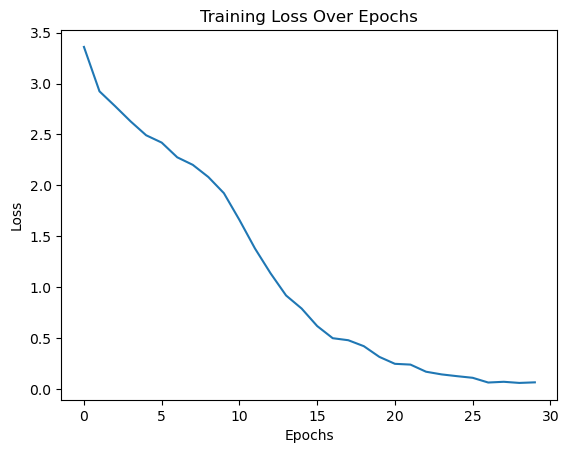

In [23]:
import matplotlib.pyplot as plt 

plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

In [30]:
print("Final loss after 30 epochs:", round(losses[-1],2))
print("Final training accuracy:", round(correct_predictions/total_predictions,2))

Final loss after 30 epochs: 0.06
Final training accuracy: 0.98


In [24]:
print(model)

ImageRNN(
  (cnn): CNNFeatureExtractor(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [25]:
torch.save(model, "rnn_overfit.pth")

### Evaluating after overfitting to small portion of dataset

In [10]:
# Need to first create a new Dataset and Dataloader that also return tracklet ID's

class TrackletTestDataset(IterableDataset):
    def __init__(self, img_dir, gt_file, transform=None, tracklet_ids=None):
        super().__init__()
        self.img_dir = img_dir
        self.gt_file = gt_file
        self.transform = transform
        with open(gt_file, "r") as f:
            self.gt_data = json.load(f)
        if tracklet_ids == None:
            self.tracklet_ids = [d for d in os.listdir(img_dir) if os.path.isdir(os.path.join(img_dir, d))]
        else:
            self.tracklet_ids = tracklet_ids

    def __iter__(self):
        """
        Generator function for streaming the dataset.
        Yields: (tracklet_tensor, label)
        """
        for tracklet_id in tqdm(self.tracklet_ids, desc="Streaming tracklets"):
            tracklet_path = os.path.join(self.img_dir, tracklet_id)
            label = self.gt_data[tracklet_id]

            # Load images one by one
            images = []
            for filename in sorted(os.listdir(tracklet_path)):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(tracklet_path, filename)
                    try:
                        img = Image.open(img_path).convert("RGB")
                        if self.transform:
                            img = self.transform(img)
                        images.append(img)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
                        continue

            if len(images) == 0:
                continue

            tracklet_tensor = torch.stack(images)

            # Use 0 for the illegible class (CrossEntropyLoss requires labels starting at 0)
            label_tensor = torch.tensor(0 if label == -1 else label)

            yield tracklet_tensor, label_tensor, str(tracklet_id)

def test_collate_fn(batch):
    """
    Since some tracklets are longer than others, we need a custom collate function to divide them into batches.
    Our approach pads each sequence to the length of the longest sequence so it may be passed to nn.utils.rnn.pack_padded_sequence().
    Each element in the batch is a tuple (tracklet_tensor, label), where each tracklet_tensor has shape (max_seq_len, C, H, W).
    """
    tracklets, labels, tracklet_ids = zip(*batch)
    seq_lengths = [t.shape[0] for t in tracklets]

    # Sort the batch in descending order of sequence lengths
    sorted_indices = sorted(range(len(seq_lengths)), key=lambda i: seq_lengths[i], reverse=True)
    sorted_tracklets = [tracklets[i] for i in sorted_indices]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_seq_lengths = [seq_lengths[i] for i in sorted_indices]
    sorted_tracklet_ids = [tracklet_ids[i] for i in sorted_indices]

    # Pad the tracklet sequences to the maximum sequence length in the batch
    padded_tracklets = pad_sequence(sorted_tracklets, batch_first=True)

    return padded_tracklets, torch.tensor(sorted_seq_lengths), torch.tensor(sorted_labels), sorted_tracklet_ids

In [11]:
IMG_DIR_TEST = r"/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/test/images/"
GT_FILE_TEST = r"/home/user/jersey-number-recognition/replicating_results/jersey-number-pipeline/data/SoccerNet/test/test_gt.json"

BATCH_SIZE = 4

test_dataset = TrackletTestDataset(IMG_DIR_TEST, GT_FILE_TEST, transform=frame_transform)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, collate_fn=test_collate_fn)

In [35]:
full_training_model = torch.load("rnn_overfit.pth")
print(full_training_model.state_dict().keys())

odict_keys(['cnn.features.0.0.weight', 'cnn.features.0.0.bias', 'cnn.features.0.2.weight', 'cnn.features.0.2.bias', 'cnn.features.1.0.weight', 'cnn.features.1.0.bias', 'cnn.features.1.2.weight', 'cnn.features.1.2.bias', 'cnn.features.2.0.weight', 'cnn.features.2.0.bias', 'cnn.features.2.2.weight', 'cnn.features.2.2.bias', 'cnn.features.3.0.weight', 'cnn.features.3.0.bias', 'cnn.features.3.2.weight', 'cnn.features.3.2.bias', 'cnn.features.4.0.weight', 'cnn.features.4.0.bias', 'cnn.features.4.2.weight', 'cnn.features.4.2.bias', 'cnn.features.5.0.weight', 'cnn.features.5.0.bias', 'cnn.features.5.2.weight', 'cnn.features.5.2.bias', 'cnn_project.weight', 'cnn_project.bias', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'rnn.weight_ih_l1', 'rnn.weight_hh_l1', 'rnn.bias_ih_l1', 'rnn.bias_hh_l1', 'fc.weight', 'fc.bias'])


In [37]:
full_training_model.eval()
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
batch_count = 0

# Dictionary to store predictions in format expected by EvalAI: key = tracklet_id (string), value = predicted number (int)
predictions = {}

with torch.no_grad():
    for batch_idx, (tracklets, seq_lengths_cpu, labels, tracklet_ids) in enumerate(test_dataloader):
        tracklets, labels = tracklets.to(DEVICE), labels.to(DEVICE)
        seq_lengths = seq_lengths_cpu.to(DEVICE)
    
        outputs = full_training_model(tracklets, seq_lengths_cpu)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        batch_count += 1
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
        # Store each prediction, replacing 0 with -1
        for i, t_id in enumerate(tracklet_ids):
            pred_value = predicted[i].item()
            if pred_value == 0:
                pred_value = -1
            predictions[str(t_id)] = pred_value

average_loss = test_loss / batch_count
accuracy = (correct_predictions / total_predictions) * 100

print(f"Test Loss: {average_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
with open("overfit_test_preds.json", "w") as f:
    json.dump(predictions, f)

Streaming tracklets: 100%|██████████████████████████████████████████████████████████| 1211/1211 [35:27<00:00,  1.76s/it]


Test Loss: 5.6081, Test Accuracy: 19.98%


In [39]:
print(set(predictions.values()))

{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 36, 40, 44, 50, -1}


### Full training

In [13]:
# Creating a new class with the same layers but this time the CNN is also trainable.

class FinalImageRNN(nn.Module):
    
    # Init remains the same
    def __init__(self, cnn_model, hidden_dim=512, num_layers=2, rnn_output_dim=100, rnn_type="LSTM", cnn_feature_dim=256):
        super(FinalImageRNN, self).__init__()
        # CNN feature extractor without the fc block
        self.cnn = CNNFeatureExtractor(cnn_model)
        # CNN output dimension is 1024 * 2 * 2 = 4096
        self.cnn_out_dim = 1024 * 2 * 2  
        # Projection layer: from 4096 to 256
        self.cnn_project = nn.Linear(self.cnn_out_dim, cnn_feature_dim)
        # RNN layer: input dimension is cnn_feature_dim
        rnn_cls = nn.LSTM if rnn_type == 'LSTM' else nn.GRU
        self.rnn = rnn_cls(input_size=cnn_feature_dim, hidden_size=hidden_dim, 
                           num_layers=num_layers, batch_first=True)
        # Final output layer
        self.fc = nn.Linear(hidden_dim, rnn_output_dim)

    def forward(self, x, seq_lengths):
        """
        x: Tensor of shape (batch_size, seq_len, C, H, W)
        seq_lengths: Tensor or list of actual sequence lengths for each tracklet.
        """
        batch_size, seq_len, C, H, W = x.shape
        cnn_features = []
#         print(seq_len)
        # Process each frame in the sequence
        for i in range(seq_len):
            img_batch = x[:, i]  # Shape: (batch_size, C, H, W)
            
            # NO LONGER with torch.no_grad()
            features = self.cnn(img_batch)  # Shape: (batch_size, 1024, 2, 2)
            
            features = features.view(batch_size, -1)  # Flatten to (batch_size, 4096)
            features = self.cnn_project(features)       # Project to (batch_size, cnn_feature_dim)
            cnn_features.append(features)
        # Stack along the time dimension: (batch_size, seq_len, cnn_feature_dim)
        cnn_features = torch.stack(cnn_features, dim=1)
        # Pack the padded sequence
        packed_seq = pack_padded_sequence(cnn_features, lengths=seq_lengths, batch_first=True, enforce_sorted=True)
        packed_out, _ = self.rnn(packed_seq)
        # Unpack the sequence
        padded_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        # For each sample, select the output at the last valid time step
        last_outputs = []
        for i, length in enumerate(seq_lengths):
            last_outputs.append(padded_out[i, length - 1, :])
        last_outputs = torch.stack(last_outputs, dim=0)
        output = self.fc(last_outputs)  # Final prediction: (batch_size, rnn_output_dim)
        return output

In [12]:
def evaluate_model(model, eval_dataloader, criterion, device, json_filename):
    """
    Encapsulates the code run a few cells ago, so that we can evaluate the model on the test set every couple of epochs.
    """
    model.eval()
    eval_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    batch_count = 0
    predictions = {}  # To store predictions for each tracklet

    with torch.no_grad():
        for batch_idx, (tracklets, seq_lengths_cpu, labels, tracklet_ids) in enumerate(eval_dataloader):
            tracklets, labels = tracklets.to(device), labels.to(device)
            seq_lengths = seq_lengths_cpu.to(device)
            
            outputs = model(tracklets, seq_lengths_cpu)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()
            
            batch_count += 1
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            
            for i, t_id in enumerate(tracklet_ids):
                pred_value = predicted[i].item()
                if pred_value == 0:
                    pred_value = -1
                predictions[str(t_id)] = pred_value

    average_loss = eval_loss / batch_count
    accuracy = (correct_predictions / total_predictions) * 100
    print(f"Evaluation - Loss: {average_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    with open(json_filename, "w") as f:
        json.dump(predictions, f)
    
    return average_loss, accuracy

In [13]:
BATCH_SIZE = 6
CNN_LEARNING_RATE = 1e-5 # Lower LR for CNN, since we don't want the features to change faster than the RNN can learn 
RNN_LEARNING_RATE = 1e-4
FC_LEARNING_RATE = 1e-4 
EPOCHS = 6
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
dataset = TrackletDataset(os.path.join(IMG_DIR), os.path.join(GT_FILE), transform=frame_transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=2, collate_fn=collate_fn)

In [19]:
torch.cuda.empty_cache()

In [20]:
trainable_cnn_model = torch.load("test_cnn.pth", weights_only=False)

In [21]:
overfit_state_dict = torch.load("rnn_overfit.pth", map_location=DEVICE).state_dict()

full_training_model = ImageRNN(cnn_model=trainable_cnn_model, hidden_dim=512, num_layers=2, cnn_feature_dim=512)
full_training_model.to(DEVICE)

# Load state dict from the previously trained (overfitted on 15% of dataset) RNN 
full_training_model.load_state_dict(overfit_state_dict, strict=True) 

criterion = nn.CrossEntropyLoss()  
full_training_optimizer = optim.Adam(full_training_model.parameters(), lr=LEARNING_RATE)

In [ ]:
# For per-epoch graph
full_training_losses = []
full_training_acc = []
# For per-batch graph
batch_losses = []
batch_accuracies = []

In [ ]:
log_file = "full_training_logs.txt"

# Write everything being printed to a text file to monitor performance.
with open(log_file, "a") as f:
    for epoch in range(1,EPOCHS):
        full_training_model.train()  # 
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        batch_count = 0  # Keeps track of the number of batches in each epoch

        for batch_idx, (tracklets, seq_lengths_cpu, labels) in enumerate(dataloader):
            tracklets, labels = tracklets.to(DEVICE), labels.to(DEVICE)
            seq_lengths_gpu = seq_lengths_cpu.to(DEVICE)

            full_training_optimizer.zero_grad()
            outputs = full_training_model(tracklets, seq_lengths_cpu)
            loss = criterion(outputs, labels)
            loss.backward()
            full_training_optimizer.step()

            # Batch statistics
            batch_loss = loss.item()
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).sum().item()
            batch_accuracy = (batch_correct / labels.size(0)) * 100
            batch_losses.append(batch_loss)
            batch_accuracies.append(batch_accuracy)

            # Track per-epoch stats
            running_loss += batch_loss
            correct_predictions += batch_correct
            total_predictions += labels.size(0)
            batch_count += 1

            # Print batch info every 10 batches
            if (batch_idx + 1) % 10 == 0:
                batch_log_msg = (
                    f"Epoch {epoch + 1}/{EPOCHS}, Batch {batch_idx + 1}, Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%"
                )
                print(batch_log_msg)
                f.write(batch_log_msg + "\n")

        epoch_loss = running_loss / batch_count
        accuracy = correct_predictions / total_predictions * 100

        full_training_losses.append(epoch_loss)
        full_training_acc.append(accuracy)

        epoch_log_msg = (
            f"\nEpoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%\n"
        )
        print(epoch_log_msg)
        f.write(epoch_log_msg)

        # Evaluate on test set every other epoch so we can keep track of learning. Also a good idea to save the weights
        if (epoch + 1) % 2 == 0:
            eval_json_filename = f"evaluation_epoch_{epoch+1}.json"
            avg_test_loss, test_accuracy = evaluate_model(full_training_model, test_dataloader, criterion, DEVICE, eval_json_filename)
            eval_log_msg = (
                f"Evaluation after epoch {epoch+1}: \nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%"
            )
            print(eval_log_msg)
            f.write(eval_log_msg + "\n")
            
            weights_filename = f"model_weights_epoch_{epoch+1}.pt"
            torch.save(full_training_model.state_dict(), weights_filename)
            save_log_msg = f"Saved model weights at: {weights_filename}\n"
            print(save_log_msg)
            f.write(save_log_msg)
            

In [ ]:
with open(log_file, "a") as f:
    for epoch in range(6,12):
        full_training_model.train()  # 
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        batch_count = 0  # Keeps track of the number of batches in each epoch

        for batch_idx, (tracklets, seq_lengths_cpu, labels) in enumerate(dataloader):
            tracklets, labels = tracklets.to(DEVICE), labels.to(DEVICE)
            seq_lengths_gpu = seq_lengths_cpu.to(DEVICE)

            full_training_optimizer.zero_grad()
            outputs = full_training_model(tracklets, seq_lengths_cpu)
            loss = criterion(outputs, labels)
            loss.backward()
            full_training_optimizer.step()

            # Batch statistics
            batch_loss = loss.item()
            _, predicted = torch.max(outputs, 1)
            batch_correct = (predicted == labels).sum().item()
            batch_accuracy = (batch_correct / labels.size(0)) * 100
            batch_losses.append(batch_loss)
            batch_accuracies.append(batch_accuracy)

            # Track per-epoch stats
            running_loss += batch_loss
            correct_predictions += batch_correct
            total_predictions += labels.size(0)
            batch_count += 1

            # Print batch info every 10 batches
            if (batch_idx + 1) % 10 == 0:
                batch_log_msg = (
                    f"Epoch {epoch + 1}/{EPOCHS}, Batch {batch_idx + 1}, Loss: {batch_loss:.4f}, Accuracy: {batch_accuracy:.2f}%"
                )
                print(batch_log_msg)
                f.write(batch_log_msg + "\n")

        epoch_loss = running_loss / batch_count
        accuracy = correct_predictions / total_predictions * 100

        full_training_losses.append(epoch_loss)
        full_training_acc.append(accuracy)

        epoch_log_msg = (
            f"\nEpoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%\n"
        )
        print(epoch_log_msg)
        f.write(epoch_log_msg)

        # Evaluate on test set every other epoch so we can keep track of learning. Also a good idea to save the weights
        if (epoch + 1) % 2 == 0:
            eval_json_filename = f"evaluation_epoch_{epoch+1}.json"
            avg_test_loss, test_accuracy = evaluate_model(full_training_model, test_dataloader, criterion, DEVICE, eval_json_filename)
            eval_log_msg = (
                f"Evaluation after epoch {epoch+1}: \nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%"
            )
            print(eval_log_msg)
            f.write(eval_log_msg + "\n")
            
            weights_filename = f"model_weights_epoch_{epoch+1}.pt"
            torch.save(full_training_model.state_dict(), weights_filename)
            save_log_msg = f"Saved model weights at: {weights_filename}\n"
            print(save_log_msg)
            f.write(save_log_msg)
            

In [ ]:
import matplotlib.pyplot as plt

plt.plot(full_training_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()